# Notebook for clustering on HPC data gathered from CFD folders
## This notebook takes data generated by the module runcrawler and tries to find clusters in the runs to be able to sort runs, see if they converge or crash due to the same reasons (for example a code version).

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#sns.set(font_scale=1.5)
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Here we create a dataframe from all the json files gathered by runcrawler.py in the DATABASE folder.

In [3]:
df = pd.DataFrame()
for filename in glob.glob('./DATABASE/*.json'):
    with open(filename) as json_file:
        data = json.load(json_file)
        new = json_normalize(data['log_monitoring'][0]['contents'])
        new['User_name'] = filename.split('__')[3]
        df= pd.concat([df, new])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


We add an index for each run. So when we visualize the head of the dataframe (i.e. the 5 first lines, 
we see each line is a run, each column is a run feature.)

In [4]:
ind = np.arange(0, len(df), 1)
ind = pd.Series(ind)
df['index_run'] = ind.values
df = df.set_index('index_run')
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 28 columns):
User_name                            217 non-null object
creation_time                        217 non-null object
err_log                              217 non-null object
params.CFL                           217 non-null object
params.LES_model                     217 non-null object
params.artificial_viscosity_model    217 non-null object
params.convection_scheme             217 non-null object
params.mixture_name                  217 non-null object
params.ncell_group                   209 non-null object
params.partitioner                   208 non-null object
params.reactive_flow                 217 non-null int64
params.real_gas                      108 non-null float64
params.smu2                          214 non-null object
params.solver_type                   217 non-null object
params.two_phase_flow                66 non-null float64
vars.AVBP_version                    193

Here is the list of all features: 
- the ones starting with params come from the run.params file
- the ones starting with vars were gathered from the log file coming out from AVBP.

In [5]:
df.columns

Index(['User_name', 'creation_time', 'err_log', 'params.CFL',
       'params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name', 'params.ncell_group',
       'params.partitioner', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.solver_type', 'params.two_phase_flow',
       'vars.AVBP_version', 'vars.CPU_time_s', 'vars.MPI_processes',
       'vars.dimension', 'vars.elapsed_time', 'vars.final_iteration',
       'vars.initial_iteration', 'vars.initial_time', 'vars.mesh_cells',
       'vars.nodes', 'vars.number_of_probes', 'vars.physical_time',
       'vars.time_per_ite'],
      dtype='object')

In [6]:
print('The dataframe contains', len(df), 'runs and contains',  len(df.columns), 'features or run parameters')

The dataframe contains 217 runs and contains 28 features or run parameters


## Data cleaning: 
- some filling of NaN values

First, we are going to print how much NaN values we have and fill them or handle them the best we can,
for example we see that the parameter 'smu2' has 1484 NaN values, so if we drop all runs that are in this case, we are going to drop half the database!! But if 'smu2' is NaN, we can replace it by 0, because if it's a Nan, it is just that it has not
been found in the run.params file, but it's normal, it's probably because it was with a run that didn't have any smu2 
parameter specified.

In [7]:
df.isnull().sum()

User_name                              0
creation_time                          0
err_log                                0
params.CFL                             0
params.LES_model                       0
params.artificial_viscosity_model      0
params.convection_scheme               0
params.mixture_name                    0
params.ncell_group                     8
params.partitioner                     9
params.reactive_flow                   0
params.real_gas                      109
params.smu2                            3
params.solver_type                     0
params.two_phase_flow                151
vars.AVBP_version                     24
vars.CPU_time_s                       36
vars.MPI_processes                    29
vars.dimension                         5
vars.elapsed_time                     28
vars.final_iteration                  34
vars.initial_iteration                 7
vars.initial_time                      7
vars.mesh_cells                        6
vars.nodes      

In [8]:
df['User_name'].unique()

array(['dupuy', 'potier', 'rossi', 'gullaud', 'pouech'], dtype=object)

In [9]:
# Anonymisation des user names
dict = { 'gullaud': 'User 1', 'rossi': 'User 2', 
        'pouech': 'User 3', 'dupuy': 'User 4', 'potier': 'User 5' }

df['User_name'] = df['User_name'].map(dict)

In [10]:
# un run qui a Nan en nb of probes est un run qui n'a pas de probes
df['vars.number_of_probes'] = df['vars.number_of_probes'].fillna(0.0)
df['params.real_gas'] = df['params.real_gas'].fillna(0.0)
# un run qui n'a pas tourné a 0 en CPU_time ...
df['vars.CPU_time_s'] = df['vars.CPU_time_s'].fillna(0.0)
df['params.two_phase_flow'] = df['params.two_phase_flow'].fillna(0.0)
df['vars.physical_time'] = df['vars.physical_time'].fillna(0.0)
df['vars.elapsed_time'] = df['vars.elapsed_time'].fillna(0.0)
df['vars.final_iteration'] = df['vars.final_iteration'].fillna(0.0)
df['vars.initial_time'] = df['vars.initial_time'].fillna(0.0)
df['params.smu2'] = df['params.smu2'].fillna(0.0)
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)

If LES is no, we replace it by DNS (Direct Numerical Simulation) for better understanding:

In [11]:
# si LES = no alors on remplace par DNS.
df['params.LES_model'] = df['params.LES_model'].apply(lambda x: 'DNS' if x=='no' else x )

There seems to be a case sensitive issue in AVBP with the "colin_species" artificial viscosity model. But we don't want 
it to be understood as if it was two different models.

In [12]:
# traitement de la redondance Colin_species vs colin_species
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'no visc model' if x =='no' else x)
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'colin_species' if x == 'Colin_species' else x)
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'Jameson' if x == 'jameson' else x)


In [13]:
df['params.solver_type'] = df['params.solver_type'].apply(lambda x: 'ns' if (x =='NS' or x =='Ns') else x)

In [14]:
df = df.dropna(subset=['vars.nodes'])

In [15]:
df = df.dropna(subset=['vars.time_per_ite'])
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset=['params.ncell_group'])

Some parameters are understood as strings so we have to convert them to integers or floats.

In [16]:
df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['params.smu2'] = df['params.smu2'].apply(lambda x: float(x))

Let's just check we don't have any more NaN in our data:

In [17]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   1
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               1
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

We drop the remaining NaN values

In [18]:
df = df.dropna()

In [19]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   0
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               0
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

## Data separation into 2 dataframes, one from setup, the other one from run log.

We split the dataframe into two dataframes, one of run setup, which can be the parameters read in run.params, and one read in avbp.o giving the HPC parameters.

In [20]:
run_setup = ['params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version', 'vars.dimension', 
       'vars.mesh_cells', 'vars.number_of_probes']

In [21]:
run_result = ['creation_time', 'err_log','vars.CPU_time_s', 'vars.elapsed_time', 
              'vars.final_iteration', 'vars.initial_iteration',
               'vars.initial_time', 'vars.physical_time', 'vars.time_per_ite' ,
               'params.ncell_group', 'params.partitioner', 'vars.MPI_processes', 'User_name']

In [22]:
df_setup = df[run_setup]

In [23]:
df_log = df[run_result]

In [24]:
df_setup.head()

params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                      DNS                     no visc model   
2                     wale                     colin_species   
3                     wale                     colin_species   
5                    sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.reactive_flow  \
index_run                                                                      
0                             TTGC          KERO_LUCHE                     1   
1                               LW                 AIR                     0   
2                             TTGC          KERO_LUCHE                     1   
3                             TTGC                C3H8                     1   
5                               LW                 AIR                     0   

           params.real_gas  params.smu2 params.solver_type  \
index_run                                                    
0                      0.0          1.0                 ns   
1                      0.0          0.0                 ns   
2                      0.0          1.0                 ns   
3                      0.0          0.0                 ns   
5                      0.0          0.0                 ns   

           params.two_phase_flow vars.AVBP_version  vars.dimension  \
index_run                                                            
0                            0.0             7.3.0               3   
1                            0.0             7.3.0               2   
2                            0.0             7.3.0               3   
3                            0.0             7.6.0               3   
5                            0.0             7.3.0               3   

           vars.mesh_cells  vars.number_of_probes  
index_run                                          
0               45486233.0                  122.0  
1                  48450.0                    0.0  
2               45469910.0                    3.0  
3               19616196.0                   72.0  
5                  47491.0                    1.0

In [25]:
df_log.head()

creation_time                   err_log  vars.CPU_time_s  \
index_run                                                                   
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]       15000000.0   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]            386.8   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]       46560000.0   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]          85080.0   
5          2019-12-12T18:33:59  [before run params, 110]            654.9   

           vars.elapsed_time  vars.final_iteration  vars.initial_iteration  \
index_run                                                                    
0                   41677.42             2084205.0               2054791.0   
1                      16.12                7854.0                     0.0   
2                   41567.26                   0.0               2993062.0   
3                     157.55                 100.0                     0.0   
5                     327.47                5039.0                     0.0   

           vars.initial_time  vars.physical_time  vars.time_per_ite  \
index_run                                                             
0                   0.085092            0.086242             1.4165   
1                   0.000000            0.120003             0.0020   
2                   0.177500            0.000000             0.3364   
3                   0.000000            0.000011             1.5336   
5                   0.000000            0.002761             0.0648   

           params.ncell_group params.partitioner  vars.MPI_processes User_name  
index_run                                                                       
0                         100           parmetis                 360    User 4  
1                         100           parmetis                  24    User 5  
2                         100           parmetis                1120    User 2  
3                          60           parmetis                 540    User 1  
5                         100           parmetis                   2    User 5

# Number of runs depending of the dimension

In [26]:
df_3D = df[df['vars.dimension'] == 3]
df_2D = df[df['vars.dimension'] == 2]
df_3D['eff'] = df_3D['vars.time_per_ite']*1000000/df_3D['vars.nodes']
df_2D['eff'] = df_2D['vars.time_per_ite']*1000000/df_2D['vars.nodes']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Work on error log

We add a column with the error code (to be continued), if the error code is 0, it means that the run is converged.
so we create a column 'CONVERGED' which can take the value 0 or 1.

In [27]:
df['error_code'] = df['err_log'].apply(lambda x: str(x).split(',')[-1][:-1].rstrip())

In [28]:
df['error_code'][0]

' 0'

In [29]:
def conversion(x):
    if x ==' 0':
        return 1
    else:
        return 0

In [30]:
df['converged'] = df['error_code'].apply(conversion)

In [31]:
df['converged']

index_run
0      1
1      1
2      1
3      1
5      0
6      1
7      1
8      1
10     1
11     1
13     1
14     1
15     1
16     1
17     0
20     1
21     1
22     1
24     1
25     1
26     1
27     1
28     0
29     1
30     1
31     1
32     1
33     1
36     1
38     1
      ..
180    1
181    1
182    1
183    1
184    1
186    1
187    1
188    1
189    1
190    0
191    1
192    0
194    1
195    1
196    1
197    1
199    1
200    0
201    0
202    1
203    1
204    1
205    0
206    1
208    1
210    0
213    1
214    0
215    1
216    1
Name: converged, Length: 176, dtype: int64

In [32]:
df[df['converged']==0]

User_name        creation_time  \
index_run                                  
5            User 5  2019-12-12T18:33:59   
17           User 2  2019-08-07T09:51:56   
28           User 4  2019-02-26T20:28:31   
44           User 5  2019-09-03T14:26:53   
46           User 2  2019-08-07T11:37:06   
52           User 3  2020-07-05T18:35:11   
58           User 2  2020-03-16T11:56:30   
60           User 1  2019-07-31T12:46:53   
69           User 1  2020-04-14T10:47:46   
71           User 1  2020-07-13T09:21:17   
78           User 1  2019-12-11T10:13:06   
80           User 5  2019-05-15T14:01:26   
82           User 3  2020-04-02T06:56:18   
86           User 1  2020-04-04T16:17:06   
91           User 5  2019-07-24T09:22:38   
93           User 5  2019-08-23T12:39:37   
97           User 5  2019-09-07T08:36:19   
98           User 3  2019-01-16T19:26:37   
100          User 3  2020-07-13T19:36:29   
104          User 5  2019-08-26T13:51:32   
106          User 3  2020-07-15T20:23:26   
111          User 4  2018-12-16T03:25:27   
115          User 3  2020-07-13T14:33:58   
122          User 5  2019-07-11T15:05:04   
127          User 2  2019-03-13T09:33:51   
129          User 4  2018-08-22T12:45:47   
131          User 1  2020-04-17T14:58:02   
134          User 5  2019-07-11T15:04:58   
136          User 5  2019-07-11T15:05:10   
140          User 3  2020-04-22T05:26:55   
147          User 5  2019-05-15T14:01:26   
152          User 4  2019-02-28T21:40:19   
155          User 4  2019-02-02T07:36:20   
156          User 4  2018-10-02T23:48:33   
163          User 5  2019-05-15T14:01:26   
166          User 5  2019-07-11T15:05:15   
167          User 5  2019-07-24T09:22:38   
170          User 2  2018-10-16T16:31:29   
172          User 1  2020-06-18T23:54:02   
173          User 1  2019-12-10T18:09:38   
178          User 2  2019-03-13T10:25:50   
190          User 5  2019-12-12T18:34:04   
192          User 4  2018-08-30T16:14:29   
200          User 5  2019-12-12T18:34:00   
201          User 2  2019-08-07T09:22:46   
205          User 5  2019-07-11T15:05:11   
210          User 1  2020-04-07T23:25:44   
214          User 4  2019-10-03T08:35:24   

                                               err_log params.CFL  \
index_run                                                           
5                             [before run params, 110]   70000000   
17         [wall dist ok,\n before other preproc, 290]   00000000   
28                            [before run params, 110]   70000000   
44                            [before run params, 110]   70000000   
46         [wall dist ok,\n before other preproc, 290]   00000000   
52                            [before run params, 110]   70000000   
58                            [before run params, 110]   00000000   
60         [wall dist ok,\n before other preproc, 290]   70000000   
69                            [before run params, 110]   70000000   
71                            [before run params, 110]   70000000   
78         [wall dist ok,\n before other preproc, 290]   70000000   
80                            [before run params, 110]   70000000   
82                            [before run params, 110]   70000000   
86                            [before run params, 110]   70000000   
91                            [before run params, 110]   70000000   
93                            [before run params, 110]   70000000   
97                            [before run params, 110]   70000000   
98                            [before run params, 110]   70000000   
100                           [before run params, 110]   70000000   
104                           [before run params, 110]   70000000   
106                           [before run params, 110]   70000000   
111                           [before run params, 110]   70000000   
115                           [before run params, 110]   70000000   
122                           [before run params, 110]   70000000   
127        [wal

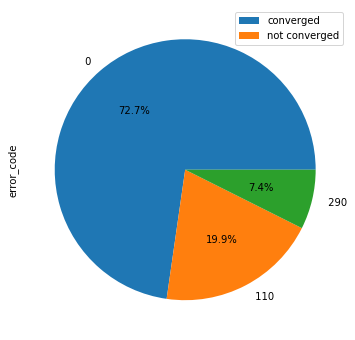

In [33]:
fig = plt.figure(figsize = (10,6))
df['error_code'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
state=['converged', 'not converged']
plt.legend(['converged', 'not converged'])
#plt.legend(loc = 1)

## PCA on setup

We start by performing a Principal Component Analysis (PCA) to reduce dimension. Remember we have 26 features describing
the runs, we want to be able to represent them in 2D for example.

To start with, we are going to use only the dataframe from the setup, so mainly using data that come from the run.params, physical parameters describing the run even if we might use some data from the log such as the code version.

We start by working on the data by 
- removing remaining NaN if any, 
- drop some features that have 0 standard deviation,
- convert strings into numerical data,
- perform one-hot-encoding on categorical data.

Now we import packages from scikit-learn to use the well-known PCA model.

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [35]:
df_setup.columns

Index(['params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version',
       'vars.dimension', 'vars.mesh_cells', 'vars.number_of_probes'],
      dtype='object')

We create a dataframe for PCA, which we call df_pca and another dataframe, containing also the info of whether the
run converged or not.

In [36]:
df_pca = df_setup
df_pca_c = pd.concat([df_setup, df['converged']], axis = 1)
df_pca = df_pca_c

In [37]:
df_pca.head()

params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                      DNS                     no visc model   
2                     wale                     colin_species   
3                     wale                     colin_species   
5                    sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.reactive_flow  \
index_run                                                                      
0                             TTGC          KERO_LUCHE                     1   
1                               LW                 AIR                     0   
2                             TTGC          KERO_LUCHE                     1   
3                             TTGC                C3H8                     1   
5                               LW                 AIR                     0   

           params.real_gas  params.smu2 params.solver_type  \
index_run                                                    
0                      0.0          1.0                 ns   
1                      0.0          0.0                 ns   
2                      0.0          1.0                 ns   
3                      0.0          0.0                 ns   
5                      0.0          0.0                 ns   

           params.two_phase_flow vars.AVBP_version  vars.dimension  \
index_run                                                            
0                            0.0             7.3.0               3   
1                            0.0             7.3.0               2   
2                            0.0             7.3.0               3   
3                            0.0             7.6.0               3   
5                            0.0             7.3.0               3   

           vars.mesh_cells  vars.number_of_probes  converged  
index_run                                                     
0               45486233.0                  122.0          1  
1                  48450.0                    0.0          1  
2               45469910.0                    3.0          1  
3               19616196.0                   72.0          1  
5                  47491.0                    1.0          0

One-hot encoding of categorical data

In [38]:
dummies_mixturename = pd.get_dummies(df_pca['params.mixture_name'])
df_pca = pd.concat([df_pca.drop('params.mixture_name', axis = 1), dummies_mixturename], axis=1)

dummies_avbpversion = pd.get_dummies(df_pca['vars.AVBP_version'])
df_pca = pd.concat([df_pca.drop('vars.AVBP_version', axis = 1), dummies_avbpversion], axis=1)

dummies_viscoartif = pd.get_dummies(df_pca['params.artificial_viscosity_model'])
df_pca = pd.concat([df_pca.drop('params.artificial_viscosity_model', axis = 1), dummies_viscoartif], axis=1)
#'params.convection_scheme'
dummies_convection_scheme = pd.get_dummies(df_pca['params.convection_scheme'])
df_pca = pd.concat([df_pca.drop('params.convection_scheme', axis = 1), dummies_convection_scheme], axis=1)
                                    
#'params.LES_model'
dummies_LES_model = pd.get_dummies(df_pca['params.LES_model'])
df_pca = pd.concat([df_pca.drop('params.LES_model', axis = 1), dummies_LES_model], axis=1)                                                       
#  


In [39]:
#'params.solver_type'
dummies_solver_type = pd.get_dummies(df_pca['params.solver_type'])
df_pca = pd.concat([df_pca.drop('params.solver_type', axis = 1), dummies_solver_type], axis = 1)

In [40]:
df_pca = df_pca.dropna()

In [41]:
# on peut supprimer le nombre de probes si on pense que on ne veut pas classer par rapport à cette variable
df_pca = df_pca.drop('vars.number_of_probes', axis = 1)

In [42]:
df_pca_c = df_pca
df_pca = df_pca.drop('converged', axis = 1)

In [43]:
print(len(df_pca_c))

176


In [44]:
print("We have a dataframe that contains", len(df_pca_c), "runs and", len(df_pca.columns), "features \
     that we want to boil down to 2 with the PCA: ")

We have a dataframe that contains 176 runs and 44 features      that we want to boil down to 2 with the PCA: 


In [45]:
df_pca.columns

Index(['params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.two_phase_flow', 'vars.dimension', 'vars.mesh_cells',
       '1S_C3H8_BFER', '2S_propane', 'AIR', 'AIR_QPF_Vortex', 'C3H8',
       'C3H8_22_173_12_FC', 'C3H8_23_274_10_PP', 'CH4', 'CH4_19_184_11_LU',
       'CH4_53_634_0_GRI', 'CH4_LU_19', 'KERO_LUCHE', 'N2_qpf',
       'N2_qpf_poiseuille', 'N2_qpf_poiseuille_2D', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'no visc model', 'LW',
       'LW_FE', 'TTG4A', 'TTGC', 'DNS', 'sigma', 'smago', 'wale', 'euler',
       'ns'],
      dtype='object')

In [46]:
print(len(df_pca), len(df_pca_c))

176 176


Now we have a dataframe containing only numerical values, with no null values.

In [47]:
#we create an instance of PCA: we want to determine how many PCA components
#allow to keep 80 % of the standard deviation of the data
pca = PCA(n_components = 7)
# standardScaler, for each variable, withdraws the mean value and divides by std()
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data

array([[ 0.66529914,  0.        ,  1.54487884, ..., -0.27050089,
        -0.17099639,  0.17099639],
       [-1.50308325,  0.        , -0.61304716, ..., -0.27050089,
        -0.17099639,  0.17099639],
       [ 0.66529914,  0.        ,  1.54487884, ...,  3.6968455 ,
        -0.17099639,  0.17099639],
       ...,
       [ 0.66529914,  0.        ,  1.54487884, ..., -0.27050089,
        -0.17099639,  0.17099639],
       [-1.50308325,  0.        , -0.61304716, ..., -0.27050089,
        -0.17099639,  0.17099639],
       [ 0.66529914,  0.        , -0.61304716, ..., -0.27050089,
        -0.17099639,  0.17099639]])

We fit the model on the scaled data:

In [48]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [49]:
len(pca.explained_variance_ratio_)

7

we create an instance of PCA: we want to determine how many PCA components
allow to keep 80 % of the standard deviation of the data

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Standard Deviation kept (%)')

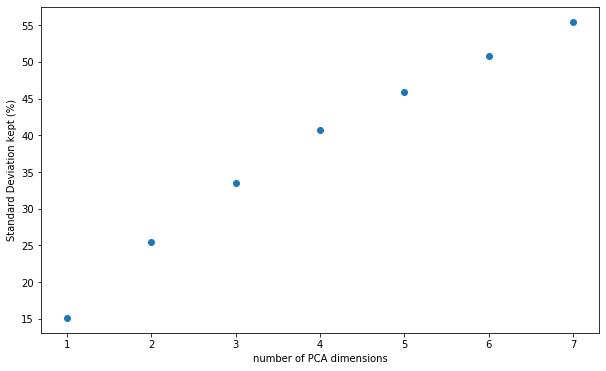

In [50]:
fig = plt.figure(figsize=(10,6))
plt.scatter(np.arange(1,8), 100*pca.explained_variance_ratio_.cumsum())
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('number of PCA dimensions')
ax.set_ylabel('Standard Deviation kept (%)')

#### We now know that we need about 3 or 4 elements in PCA to keep the standard deviation.

## PCA with 2 components

In [51]:
pca = PCA(n_components = 2)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True),
                     pd.DataFrame(scores_pca, 
                     columns = ['Component 1', 'Component 2'])], axis = 1)

In [52]:
df_comp.head()

params.reactive_flow  params.real_gas  params.smu2  params.two_phase_flow  \
0                     1              0.0          1.0                    0.0   
1                     0              0.0          0.0                    0.0   
2                     1              0.0          1.0                    0.0   
3                     1              0.0          0.0                    0.0   
4                     0              0.0          0.0                    0.0   

   vars.dimension  vars.mesh_cells  1S_C3H8_BFER  2S_propane  AIR  \
0               3       45486233.0             0           0    0   
1               2          48450.0             0           0    1   
2               3       45469910.0             0           0    0   
3               3       19616196.0             0           0    0   
4               3          47491.0             0           0    1   

   AIR_QPF_Vortex  ...  TTG4A  TTGC  DNS  sigma  smago  wale  euler  ns  \
0               0  ...      0     1    0      1      0     0      0   1   
1               0  ...      0     0    1      0      0     0      0   1   
2               0  ...      0     1    0      0      0     1      0   1   
3               0  ...      0     1    0      0      0     1      0   1   
4               0  ...      0     0    0      1      0     0      0   1   

   Component 1  Component 2  
0    -4.008343    -0.178171  
1     2.595719     1.217754  
2    -3.837432     0.118041  
3    -1.983663     0.463843  
4     0.314346     3.091856  

[5 rows x 46 columns]

In [53]:
df_pca.columns

Index(['params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.two_phase_flow', 'vars.dimension', 'vars.mesh_cells',
       '1S_C3H8_BFER', '2S_propane', 'AIR', 'AIR_QPF_Vortex', 'C3H8',
       'C3H8_22_173_12_FC', 'C3H8_23_274_10_PP', 'CH4', 'CH4_19_184_11_LU',
       'CH4_53_634_0_GRI', 'CH4_LU_19', 'KERO_LUCHE', 'N2_qpf',
       'N2_qpf_poiseuille', 'N2_qpf_poiseuille_2D', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'no visc model', 'LW',
       'LW_FE', 'TTG4A', 'TTGC', 'DNS', 'sigma', 'smago', 'wale', 'euler',
       'ns'],
      dtype='object')

In [54]:
df_pcacomponents = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
df_pcacomponents

params.reactive_flow  params.real_gas  params.smu2  params.two_phase_flow  \
0              0.159569              0.0     0.327564           0.000000e+00   
1              0.303735              0.0     0.057126           3.330669e-16   

   vars.dimension  vars.mesh_cells  1S_C3H8_BFER  2S_propane       AIR  \
0        0.302529         0.336506      0.009264    0.008269  0.085061   
1        0.085022         0.003834      0.040354    0.031197  0.279263   

   AIR_QPF_Vortex  ...        LW     LW_FE     TTG4A      TTGC       DNS  \
0        0.033308  ...  0.126609  0.178823  0.086564  0.291012  0.305785   
1        0.006021  ...  0.292112  0.322097  0.054513  0.071287  0.185733   

      sigma     smago      wale     euler        ns  
0  0.294473  0.035527  0.117184  0.101101  0.101101  
1  0.001288  0.246778  0.018301  0.083998  0.083998  

[2 rows x 44 columns]

Text(114.0, 0.5, "['PCA Componant 1', 'PCA Componant 2']")

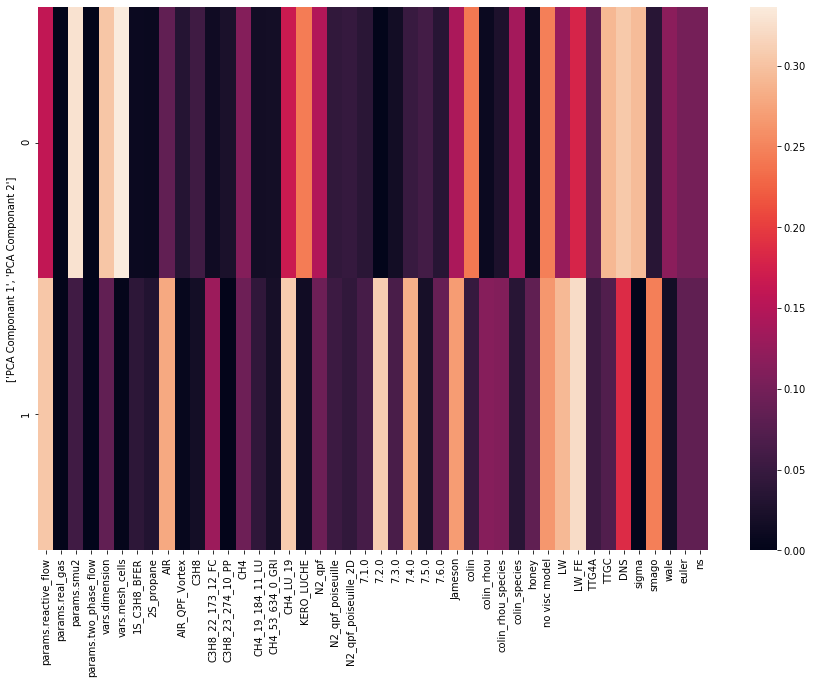

In [55]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df_pcacomponents)
ax.set_ylabel(['PCA Componant 1', 'PCA Componant 2'])

In [56]:
df_pca.columns[0]

'params.reactive_flow'

In [57]:
def biplot(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PCA Component{}".format(1), size=14)
    plt.ylabel("PCA Component{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.4,0.4])
    plt.ylim([-0.4,0.4])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[-4.00834276  2.59571888 -3.83743169 -1.98366251  0.31434616 -4.00834276
 -3.01704615  2.17549301 -3.01704615  0.4741962   2.66498627 -3.05761135
  1.72178206  2.66498627 -2.2670173  -3.30037627  1.72184117  0.54007993
 -4.00834276  1.42811113 -2.99064951  0.54007993 -4.00802094  1.32491707
  1.56603689  2.57123878  2.68135143  1.95187917  2.66498627  1.59418043
  0.69562334 -3.1670301   0.56293947 -3.1670301   1.59418043  0.96555698
 -3.98875095 -0.18236562 -4.00834276 -3.01704615 -0.97022451  2.60999967
 -1.03682314  3.16574007 -3.06461788  1.9719801  -0.63310798  2.66498627
  0.85844373  2.31798678  2.66498627  2.80226584 -2.99064951  0.57945992
  1.9719801  -2.29483181  0.87126523  2.66498627  2.66498627 -2.99064951
 -0.78442724  3.8137371   2.89969857 -0.95271977 -4.00802094  0.54007993
  0.7306964   0.57945992 -3.66201426 -1.89220222  2.66498627  2.71955022
  2.16270431  1.95187917  2.16270431  0.56293947  2.63573153  3.02080225
  1.43353585  2.27868707 -0.97022451 -2.94462372  1

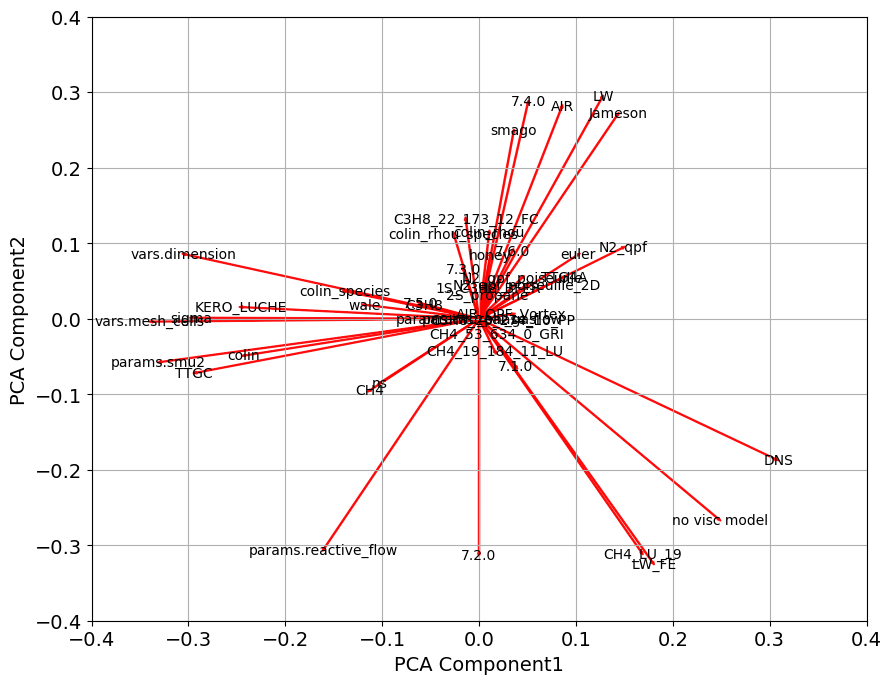

In [58]:
biplot(scores_pca, np.transpose(pca.components_))
plt.show()

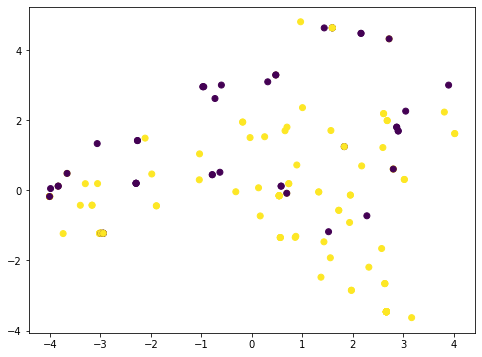

In [59]:
fig = plt.figure(figsize = (8,6))

plt.scatter(scores_pca[:,0], scores_pca[:,1], 
            c = df_pca_c['converged'], cmap = 'viridis')

## Determination du nombre de clusters optimal

In [60]:
from sklearn.cluster import KMeans

In [61]:
# on ne connait pas au préalable le nombre de clusters dans les runs
#on va maintenant montrer que le nombre de cluster optimal est bien 3
# Inertia is the sum of squared distances of samples to their closest cluster centre avec la donnée kmeans.inertia_

distance = []
for i in range(1,6):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scores_pca)
    distance.append(kmeans.inertia_)

Text(0, 0.5, 'kmeans distance')

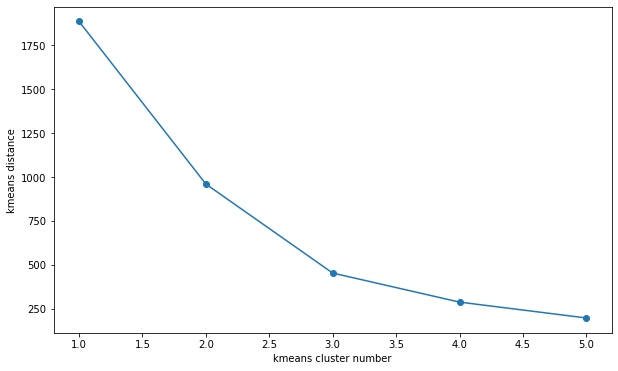

In [62]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1, 1)
plt.plot(range(1,6), distance, '-o')
ax.set_xlabel('kmeans cluster number')
ax.set_ylabel('kmeans distance')

We see that above 3 clusters in the kmeans model doesn't make the distance drop so much, so 3 is the optimal value.
We can deduce here that we have 3 big tendencies in our runs.

## Kmeans with 3 clusters 

In [63]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 2 1 1 2 1 1 2 1 2 0 1 0 0 1 1 0 2 1 0 1 2 1 2 2 0 2 2 0 2 2 1 0 1 2 2 1
 2 1 1 2 2 2 0 1 0 2 0 0 0 0 2 1 2 0 1 0 0 0 1 2 2 2 2 1 2 2 2 1 1 0 2 2 2
 2 0 0 2 2 0 2 1 2 2 0 2 2 1 2 1 2 2 0 1 0 2 1 2 1 1 2 0 1 1 1 1 1 1 0 2 0
 2 0 2 2 2 0 2 1 2 2 2 1 1 0 1 1 1 2 0 2 1 2 2 2 0 2 2 1 1 2 2 0 2 0 1 1 1
 1 1 0 2 1 0 2 2 1 1 2 2 2 1 2 2 1 1 0 2 2 2 0 1 0 1 2 0]


In [64]:
kmeans.cluster_centers_.shape

(3, 2)

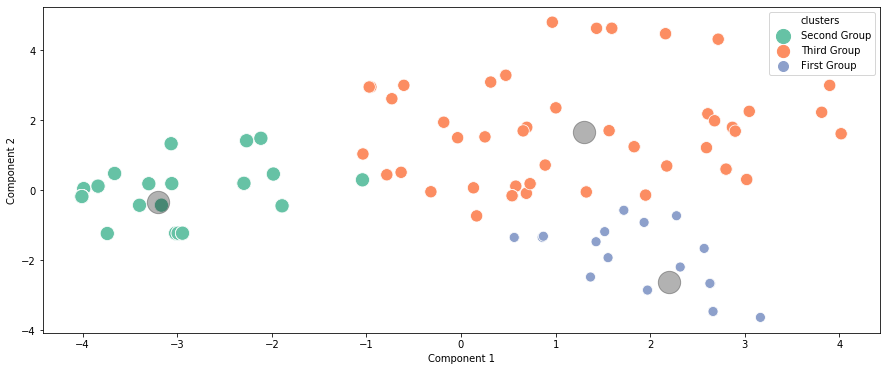

In [65]:
#ax = sns.scatterplot(x="total_bill", y="tip",
#                     hue="size", size="size",
##                     sizes=(20, 200), hue_norm=(0, 7),
#                     legend="full", data=tips)
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans

df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First Group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
df_comp['clusters'] = df_comp['k_means_pca']

fig = plt.figure(figsize = (15,6))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['clusters'], size = df_comp['clusters'],
                sizes= (100,200), palette="Set2")
#sns.scatterplot(x, y, hue = df_pca_c['converged'], 
#                palette="Set1", alpha = 0.4)
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

In [66]:
df_comp['k_means_pca_int']= df_comp['k_means_pca'].map({'First Group': 1, 'Second Group': 2, 'Third Group': 3})

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


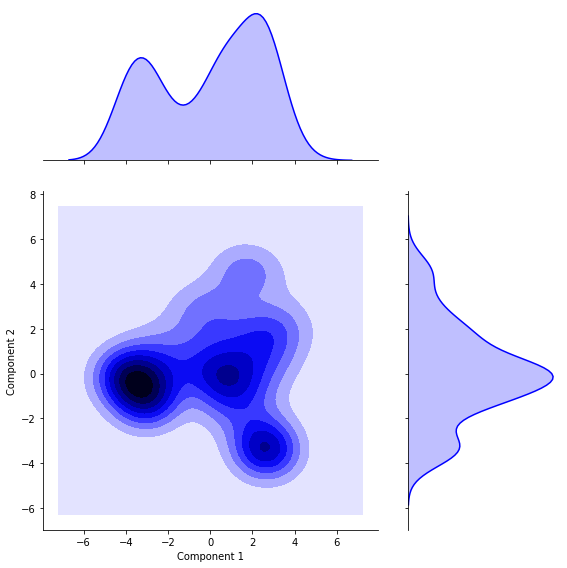

In [67]:
#fig, ax = plt.subplots(figsize=(16, 6))
x = 'Component 1'
y = 'Component 2'
hexplot = sns.jointplot(x, y, data = df_comp, kind = "kde", color = 'b', height = 8,
                        ratio = 2, hue = 'k_means_pca_int' )

In [68]:
df_comp.columns

Index(['params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.two_phase_flow', 'vars.dimension', 'vars.mesh_cells',
       '1S_C3H8_BFER', '2S_propane', 'AIR', 'AIR_QPF_Vortex', 'C3H8',
       'C3H8_22_173_12_FC', 'C3H8_23_274_10_PP', 'CH4', 'CH4_19_184_11_LU',
       'CH4_53_634_0_GRI', 'CH4_LU_19', 'KERO_LUCHE', 'N2_qpf',
       'N2_qpf_poiseuille', 'N2_qpf_poiseuille_2D', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'no visc model', 'LW',
       'LW_FE', 'TTG4A', 'TTGC', 'DNS', 'sigma', 'smago', 'wale', 'euler',
       'ns', 'Component 1', 'Component 2', 'k_means_pca', 'clusters',
       'k_means_pca_int'],
      dtype='object')

In [69]:
df_comp.head()

params.reactive_flow  params.real_gas  params.smu2  params.two_phase_flow  \
0                     1              0.0          1.0                    0.0   
1                     0              0.0          0.0                    0.0   
2                     1              0.0          1.0                    0.0   
3                     1              0.0          0.0                    0.0   
4                     0              0.0          0.0                    0.0   

   vars.dimension  vars.mesh_cells  1S_C3H8_BFER  2S_propane  AIR  \
0               3       45486233.0             0           0    0   
1               2          48450.0             0           0    1   
2               3       45469910.0             0           0    0   
3               3       19616196.0             0           0    0   
4               3          47491.0             0           0    1   

   AIR_QPF_Vortex  ...  sigma  smago  wale  euler  ns  Component 1  \
0               0  ...      1      0     0      0   1    -4.008343   
1               0  ...      0      0     0      0   1     2.595719   
2               0  ...      0      0     1      0   1    -3.837432   
3               0  ...      0      0     1      0   1    -1.983663   
4               0  ...      1      0     0      0   1     0.314346   

   Component 2   k_means_pca      clusters  k_means_pca_int  
0    -0.178171  Second Group  Second Group                2  
1     1.217754   Third Group   Third Group                3  
2     0.118041  Second Group  Second Group                2  
3     0.463843  Second Group  Second Group                2  
4     3.091856   Third Group   Third Group                3  

[5 rows x 49 columns]

In [70]:
df_temp1 = df_comp.groupby('k_means_pca').sum()[dummies_LES_model.columns]
df_temp1

DNS  sigma  smago  wale
k_means_pca                          
First Group    40      0      1     0
Second Group    0     45      3    11
Third Group    44      9     22     1

In [71]:
df_temp2 = df_comp.groupby('k_means_pca').sum()[dummies_mixturename.columns]
df_temp2

1S_C3H8_BFER  2S_propane  AIR  AIR_QPF_Vortex  C3H8  \
k_means_pca                                                         
First Group              0           0    0               0     0   
Second Group             0           0    0               0     7   
Third Group              3           1   18               3     7   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  CH4  CH4_19_184_11_LU  \
k_means_pca                                                                 
First Group                   0                  1    8                 1   
Second Group                  0                  0   26                 0   
Third Group                   5                  1   16                 0   

              CH4_53_634_0_GRI  CH4_LU_19  KERO_LUCHE  N2_qpf  \
k_means_pca                                                     
First Group                  1         30           0       0   
Second Group                 0          0          26       0   
Third Group                  0          0           0      18   

              N2_qpf_poiseuille  N2_qpf_poiseuille_2D  
k_means_pca                                            
First Group                   0                     0  
Second Group                  0                     0  
Third Group                   2                     2

In [72]:
df_temp3 = df_comp.groupby('k_means_pca').sum()[dummies_viscoartif.columns]
df_temp3

Jameson  colin  colin_rhou  colin_rhou_species  colin_species  \
k_means_pca                                                                   
First Group         0      4           0                   0              0   
Second Group        0     44           0                   0             15   
Third Group        23     28           4                   6              0   

              honey  no visc model  
k_means_pca                         
First Group       0             37  
Second Group      0              0  
Third Group       1             14

In [73]:
def plot_polar(dummies, title, df, n_clusters):
    df_temp = df.groupby('k_means_pca').sum()[dummies.columns]
    #print(df_temp)
    labels = np.array(df.groupby('k_means_pca').sum()[dummies.columns].columns)
    #print(labels)
    stats_firstgroup = np.clip(df.loc['First Group'].values/df.loc['First Group'].sum()*100, 1, 100)
    stats_secondgroup = np.clip(df.loc['Second Group'].values/df.loc['Second Group'].sum()*100, 1, 100)
    stats_thirdgroup = np.clip(df.loc['Third Group'].values/df.loc['Third Group'].sum()*100, 1, 100)
    if n_clusters ==4:
        stats_fourthgroup = np.clip(df.loc['Fourth Group'].values/df.loc['Fourth Group'].sum()*100, 1, 100)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)
    
    # close the plot
    stats_firstgroup=np.concatenate((stats_firstgroup,[stats_firstgroup[0]]))
    stats_secondgroup = np.concatenate((stats_secondgroup,[stats_secondgroup[0]]))
    stats_thirdgroup = np.concatenate((stats_thirdgroup,[stats_thirdgroup[0]]))
    if n_clusters==4:
        stats_fourthgroup = np.concatenate((stats_fourthgroup,[stats_fourthgroup[0]]))
    #print(stats_firstgroup)
    #print(stats_secondgroup)
    #print(stats_thirdgroup)
    
    angles=np.concatenate((angles,[angles[0]]))
    #print(angles)
    fig=plt.figure(figsize =(20,10))
    sns.set(font_scale=1.5)

    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats_firstgroup, 'o-', linewidth=2, color = 'r')
    ax.fill(angles, stats_firstgroup, alpha=0.25, color = 'r')
    ax.set_thetagrids(angles * 180/np.pi, labels)

    ax.grid(True)

    ax.plot(angles, stats_secondgroup, 'o-', linewidth=2, color = 'g')
    ax.fill(angles, stats_secondgroup, alpha=0.25, color = 'g')
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)


    ax.plot(angles, stats_thirdgroup, 'o-', linewidth=2, color = 'b')
    ax.fill(angles, stats_thirdgroup, alpha=0.25, color = 'b')
    ax.set_thetagrids(angles * 180/np.pi, labels)
    
    ax.set_title(title)
    ax.grid(True)
    
    plt.legend(['First Group', 'Second Group', 'Third Group'], loc =0)
    
    if n_clusters ==4:
        ax.plot(angles, stats_fourthgroup, 'o-', linewidth=2, color = 'k')
        ax.fill(angles, stats_fourthgroup, alpha=0.25, color = 'k')
        ax.set_thetagrids(angles * 180/np.pi, labels)
    
        ax.set_title(title)
        ax.grid(True)
        plt.legend(['First Group', 'Second Group', 'Third Group', 'Fourth Group'], loc =0)

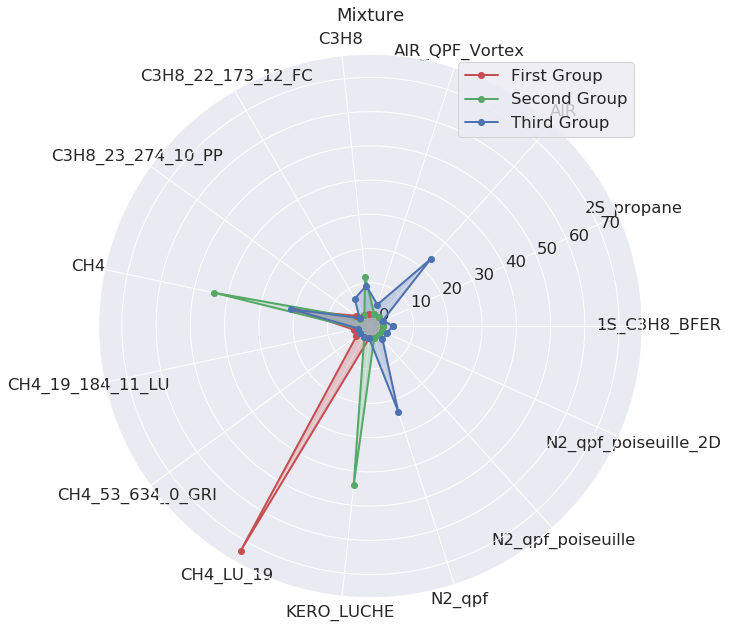

In [74]:
plot_polar(dummies_mixturename, 'Mixture', df_temp2, 3)

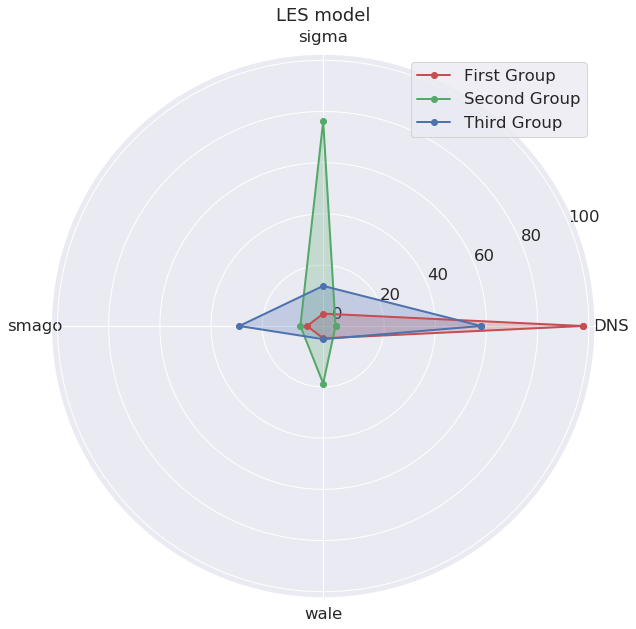

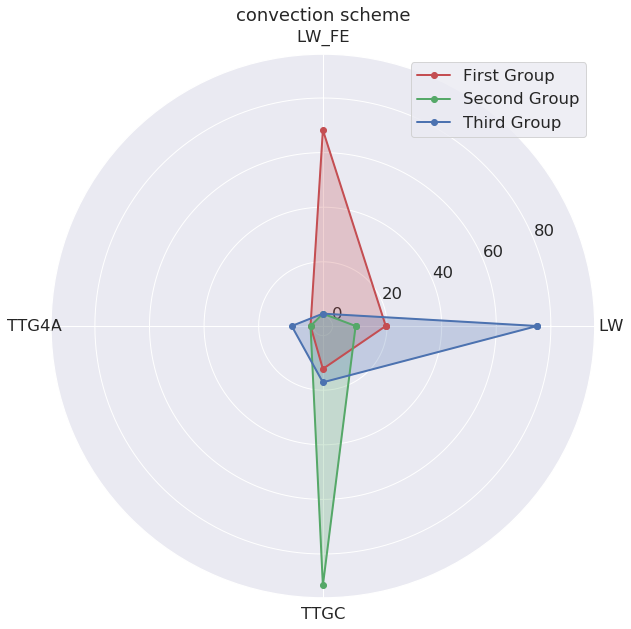

In [75]:
plot_polar(dummies_LES_model, 'LES model',
          df_comp.groupby('k_means_pca').sum()[dummies_LES_model.columns], 3)
plot_polar(dummies_convection_scheme, 'convection scheme',
          df_comp.groupby('k_means_pca').sum()[dummies_convection_scheme.columns],3)

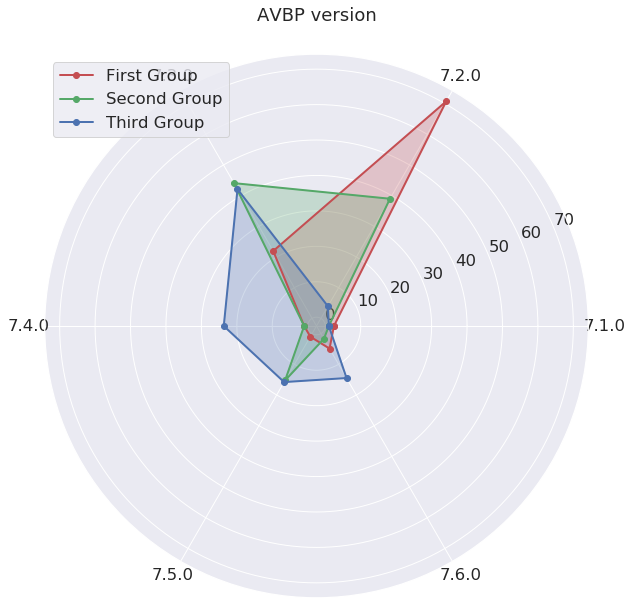

In [76]:
plot_polar(dummies_avbpversion, 'AVBP version', 
           df_comp.groupby('k_means_pca').sum()[dummies_avbpversion.columns], 3)

In [77]:
df_comp.groupby('k_means_pca').sum()[dummies_avbpversion.columns]

7.1.0  7.2.0  7.3.0  7.4.0  7.5.0  7.6.0
k_means_pca                                           
First Group       1     29      9      0      0      2
Second Group      0     23     26      0      9      1
Third Group       0      3     32     18     12     11

<Figure size 720x432 with 0 Axes>

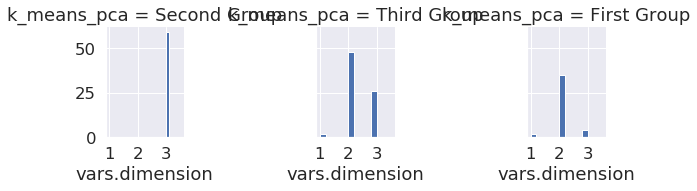

In [78]:
plt.figure(figsize = (10,6))
g = sns.FacetGrid(df_comp, col = 'k_means_pca')
g = g.map(plt.hist, 'vars.dimension')

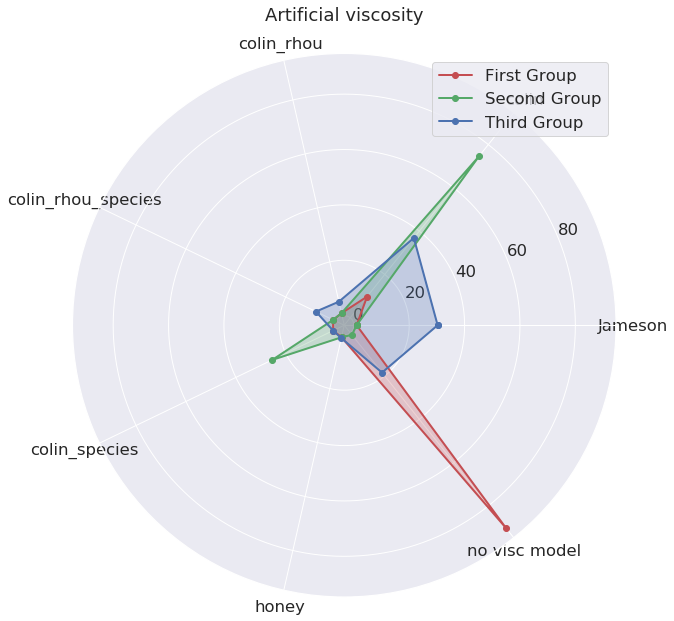

In [79]:
plot_polar(dummies_viscoartif, 'Artificial viscosity', 
           df_comp.groupby('k_means_pca').sum()[dummies_viscoartif.columns], 3)

In [80]:
df_comp.groupby('k_means_pca').sum()[dummies_LES_model.columns].loc['Third Group'].values

array([44,  9, 22,  1], dtype=uint8)

# Classifying the runs by their characteristics by groups found by k-means with 3 clusters

## LES_model

In [81]:
def plot_by_cluster(in_dummies, n_group):
    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(1,1,1)
    plotdata = pd.DataFrame(
    {"nb_runs group {}".format(n_group): df_comp.groupby('k_means_pca').sum()
     [in_dummies.columns].loc['{} Group'.format(n_group)].values}, 
    index=df_comp.groupby('k_means_pca').sum()[in_dummies.columns].loc['{} Group'.format(n_group)].index)
    plotdata.plot(kind="pie", ax = ax, subplots= True)

In [82]:
#plot_by_cluster(dummies_LES_model, 'First')
#plot_by_cluster(dummies_LES_model, 'Second')
#plot_by_cluster(dummies_LES_model, 'Third')

In [83]:
#plot_by_cluster(dummies_solver_type, 'First')
#plot_by_cluster(dummies_solver_type, 'Second')
#plot_by_cluster(dummies_solver_type, 'Third')

## Convection scheme

In [84]:
#plot_by_cluster(dummies_convection_scheme, 'First')
#plot_by_cluster(dummies_convection_scheme, 'Second')
#plot_by_cluster(dummies_convection_scheme, 'Third')

In [85]:
#plot_by_cluster(dummies_avbpversion, 'First')
#plot_by_cluster(dummies_avbpversion, 'Second')
#plot_by_cluster(dummies_avbpversion, 'Third')

## Artificial viscosity

In [86]:
#plot_by_cluster(dummies_viscoartif, 'First')
#plot_by_cluster(dummies_viscoartif, 'Second')
#plot_by_cluster(dummies_viscoartif, 'Third')

In [87]:
df_cvscheme = df_comp.groupby('k_means_pca').sum()[dummies_convection_scheme.columns].iloc[0]
df_cvscheme

LW        8
LW_FE    28
TTG4A     0
TTGC      5
Name: First Group, dtype: uint8

In [88]:
df_process_mean = df_comp.groupby('k_means_pca').mean()
df_process_mean

params.reactive_flow  params.real_gas  params.smu2  \
k_means_pca                                                        
First Group               0.975610              0.0     0.000000   
Second Group              0.898305              0.0     0.847458   
Third Group               0.381579              0.0     0.000000   

              params.two_phase_flow  vars.dimension  vars.mesh_cells  \
k_means_pca                                                            
First Group                     0.0        2.048780     1.575570e+06   
Second Group                    0.0        3.000000     3.150860e+07   
Third Group                     0.0        2.315789     1.970881e+06   

              1S_C3H8_BFER  2S_propane       AIR  AIR_QPF_Vortex  ...  \
k_means_pca                                                       ...   
First Group       0.000000    0.000000  0.000000        0.000000  ...   
Second Group      0.000000    0.000000  0.000000        0.000000  ...   
Third Group       0.039474    0.013158  0.236842        0.039474  ...   

                  TTGC       DNS     sigma     smago      wale     euler  \
k_means_pca                                                                
First Group   0.121951  0.975610  0.000000  0.024390  0.000000  0.000000   
Second Group  0.915254  0.000000  0.762712  0.050847  0.186441  0.000000   
Third Group   0.171053  0.578947  0.118421  0.289474  0.013158  0.065789   

                    ns  Component 1  Component 2  k_means_pca_int  
k_means_pca                                                        
First Group   1.000000     2.198793    -2.609477              1.0  
Second Group  1.000000    -3.206259    -0.349263              2.0  
Third Group   0.934211     1.302878     1.678882              3.0  

[3 rows x 47 columns]

In [89]:
df_comp2 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2'], axis = 1)

In [90]:
df_process_std = df_comp2.groupby('k_means_pca').std()

In [91]:
dataframe_mean = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean()], axis = 1) 
dataframe_mean.columns =  ['Mean First group', 
                      'Mean Second group',
                      'Mean Third group']


/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
dataframe_std = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].std(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe_std.columns =  ['Mean First group', 
                      'Mean Second group',
                      'Mean Third group']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'First Group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.mesh_cells           1.575570e+06     3.860761e+06       3.150860e+07   
k_means_pca_int           1.000000e+00     0.000000e+00       2.000000e+00   
vars.dimension            2.048780e+00     3.841367e-01       3.000000e+00   
ns                        1.000000e+00     0.000000e+00       1.000000e+00   
LW                        1.951220e-01     4.012177e-01       8.474576e-02   
DNS                       9.756098e-01     1.561738e-01       0.000000e+00   
7.3.0                     2.195122e-01     4.190582e-01       4.406780e-01   
colin                     9.756098e-02     3.004062e-01       7.457627e-01   
Jameson                   0.000000e+00     0.000000e+00       0.000000e+00   
smago                     2.439024e-02     1.561738e-01       5.084746e-02   
N2_qpf                    0.000000e+00     0.000000e+00       0.000000e+00   
7.4.0                     0.000000e+00     0.000000e+00       0.000000e+00   
AIR                       0.000000e+00     0.000000e+00       0.000000e+00   
CH4                       1.951220e-01     4.012177e-01       4.406780e-01   
no visc model             9.024390e-01     3.004062e-01       0.000000e+00   
TTGC                      1.219512e-01     3.312946e-01       9.152542e-01   
7.5.0                     0.000000e+00     0.000000e+00       1.525424e-01   
7.6.0                     4.878049e-02     2.180848e-01       1.694915e-02   
sigma                     0.000000e+00     0.000000e+00       7.627119e-01   
C3H8                      0.000000e+00     0.000000e+00       1.186441e-01   
colin_rhou_species        0.000000e+00     0.000000e+00       0.000000e+00   
TTG4A                     0.000000e+00     0.000000e+00       0.000000e+00   
C3H8_22_173_12_FC         0.000000e+00     0.000000e+00       0.000000e+00   
euler                     0.000000e+00     0.000000e+00       0.000000e+00   
colin_rhou                0.000000e+00     0.000000e+00       0.000000e+00   
7.2.0                     7.073171e-01     4.606464e-01       3.898305e-01   
AIR_QPF_Vortex            0.000000e+00     0.000000e+00       0.000000e+00   
1S_C3H8_BFER              0.000000e+00     0.000000e+00       0.000000e+00   
N2_qpf_poiseuille_2D      0.000000e+00     0.000000e+00       0.000000e+00   
N2_qpf_poiseuille         0.000000e+00     0.000000e+00       0.000000e+00   
C3H8_23_274_10_PP         2.439024e-02     1.561738e-01       0.000000e+00   
wale                      0.000000e+00     0.000000e+00       1.864407e-01   
2S_propane                0.000000e+00     0.000000e+00       0.000000e+00   
honey                     0.000000e+00     0.000000e+00       0.000000e+00   
CH4_53_634_0_GRI          2.439024e-02     1.561738e-01       0.000000e+00   
LW_FE                     6.829268e-01     4.711170e-01       0.000000e+00   
colin_species             0.000000e+00     0.000000e+00       2.542373e-01   
CH4_LU_19                 7.317073e-01     4.485750e-01       0.000000e+00   
7.1.0                     2.439024e-02     1.561738e-01       0.000000e+00   
CH4_19_184_11_LU          2.439024e-02     1.561738e-01       0.000000e+00   
KERO_LUCHE                0.000000e+00     0.000000e+00       4.406780e-01   
params.smu2               0.000000e+00     0.000000e+00       8.474576e-01   

                      Std Second Group  Mean Third group  Std Third Group  
vars.mesh_cells           1.476375e+07      1.970881e+06     6.820168e+06  
k_means_pca_int           0.000000e+00      3.000000e+00     0.000000e+00  
vars.dimension            0.000000e+00      2.315789e+00     5.218052e-01  
ns                        0.000000e+00      9.342105e-01     2.495610e-01  
LW                        2.808936e-01      7.500000e-01     4.358899e-01  
DNS                       0.000000e+00      5.789474e-01     4.970086e-01  
7.3.0                     5.007300e-01      4.210526e-01     4.970086e-01  
colin                     4.391693e-01      3.684211e-01   

Features that have a mean value and standard deviation of 0 are not describing at all the group=

In [94]:
not_first_group = dataframe[(dataframe['Mean First group'] == 0) & (dataframe['Std First Group'] ==0.0)].index
not_second_group = dataframe[(dataframe['Mean Second group'] == 0) & (dataframe['Std Second Group'] ==0.0)].index
not_third_group = dataframe[(dataframe['Mean Third group'] == 0) & (dataframe['Std Third Group'] ==0.0)].index

Repartition des standard deviations en fonction des groupes

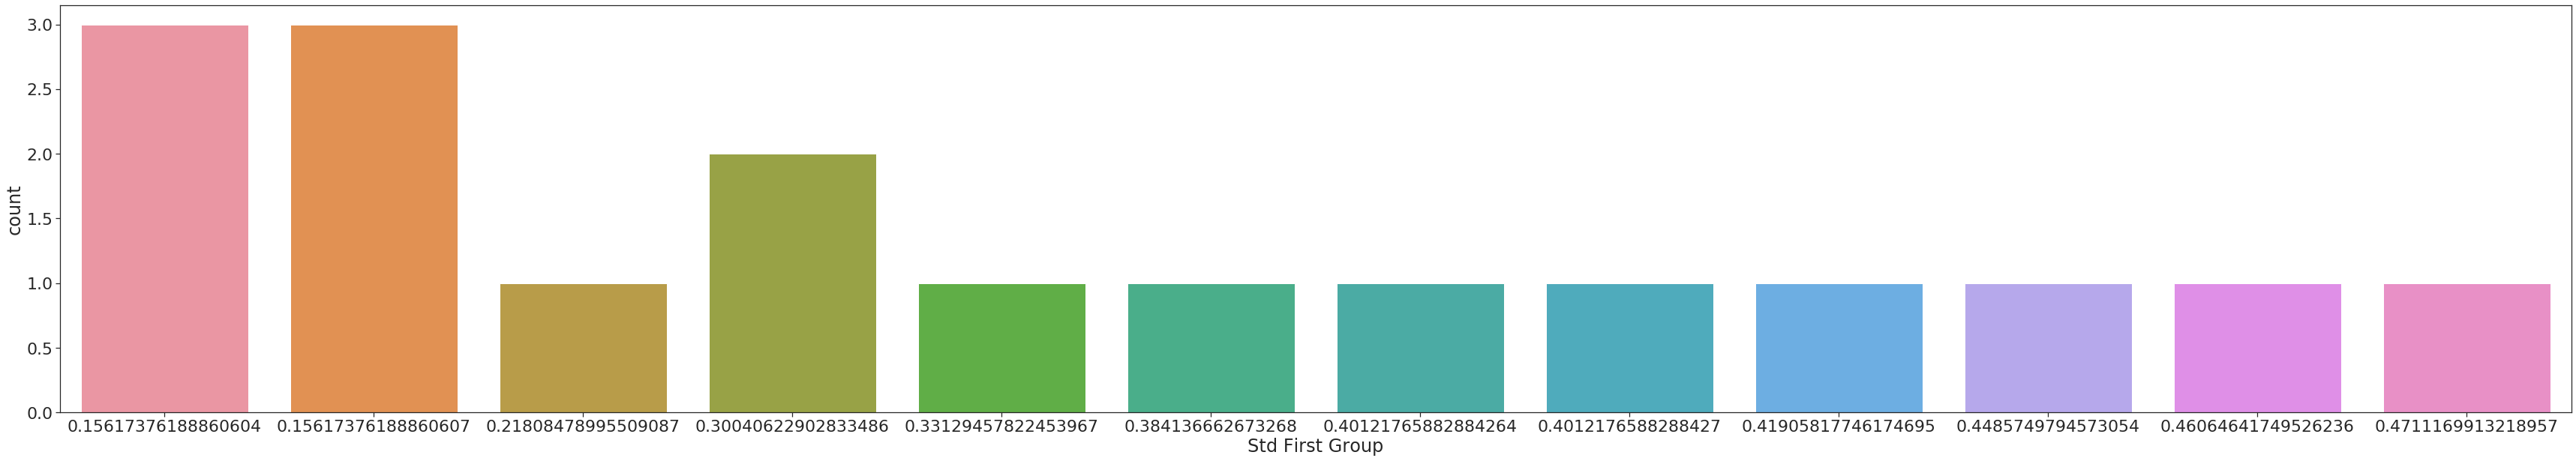

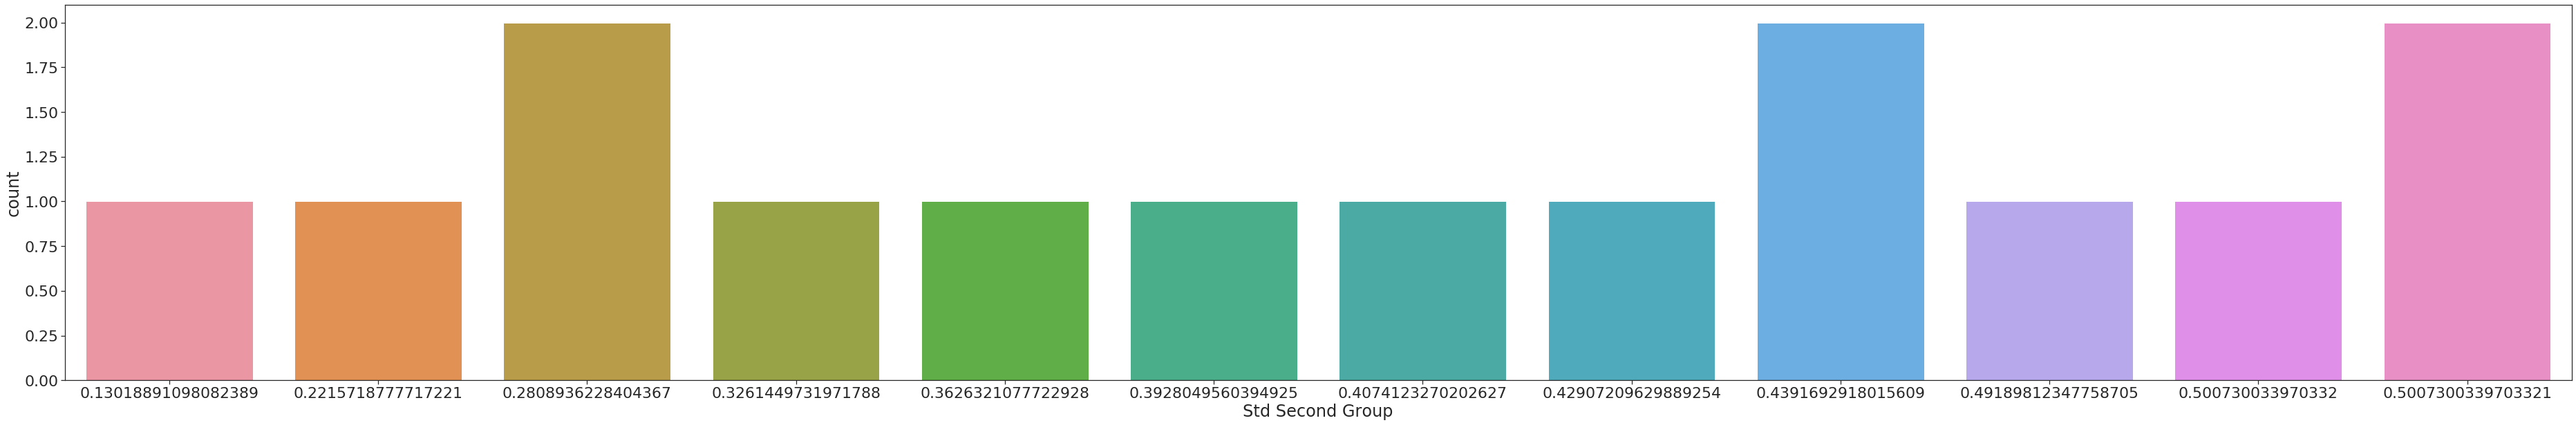

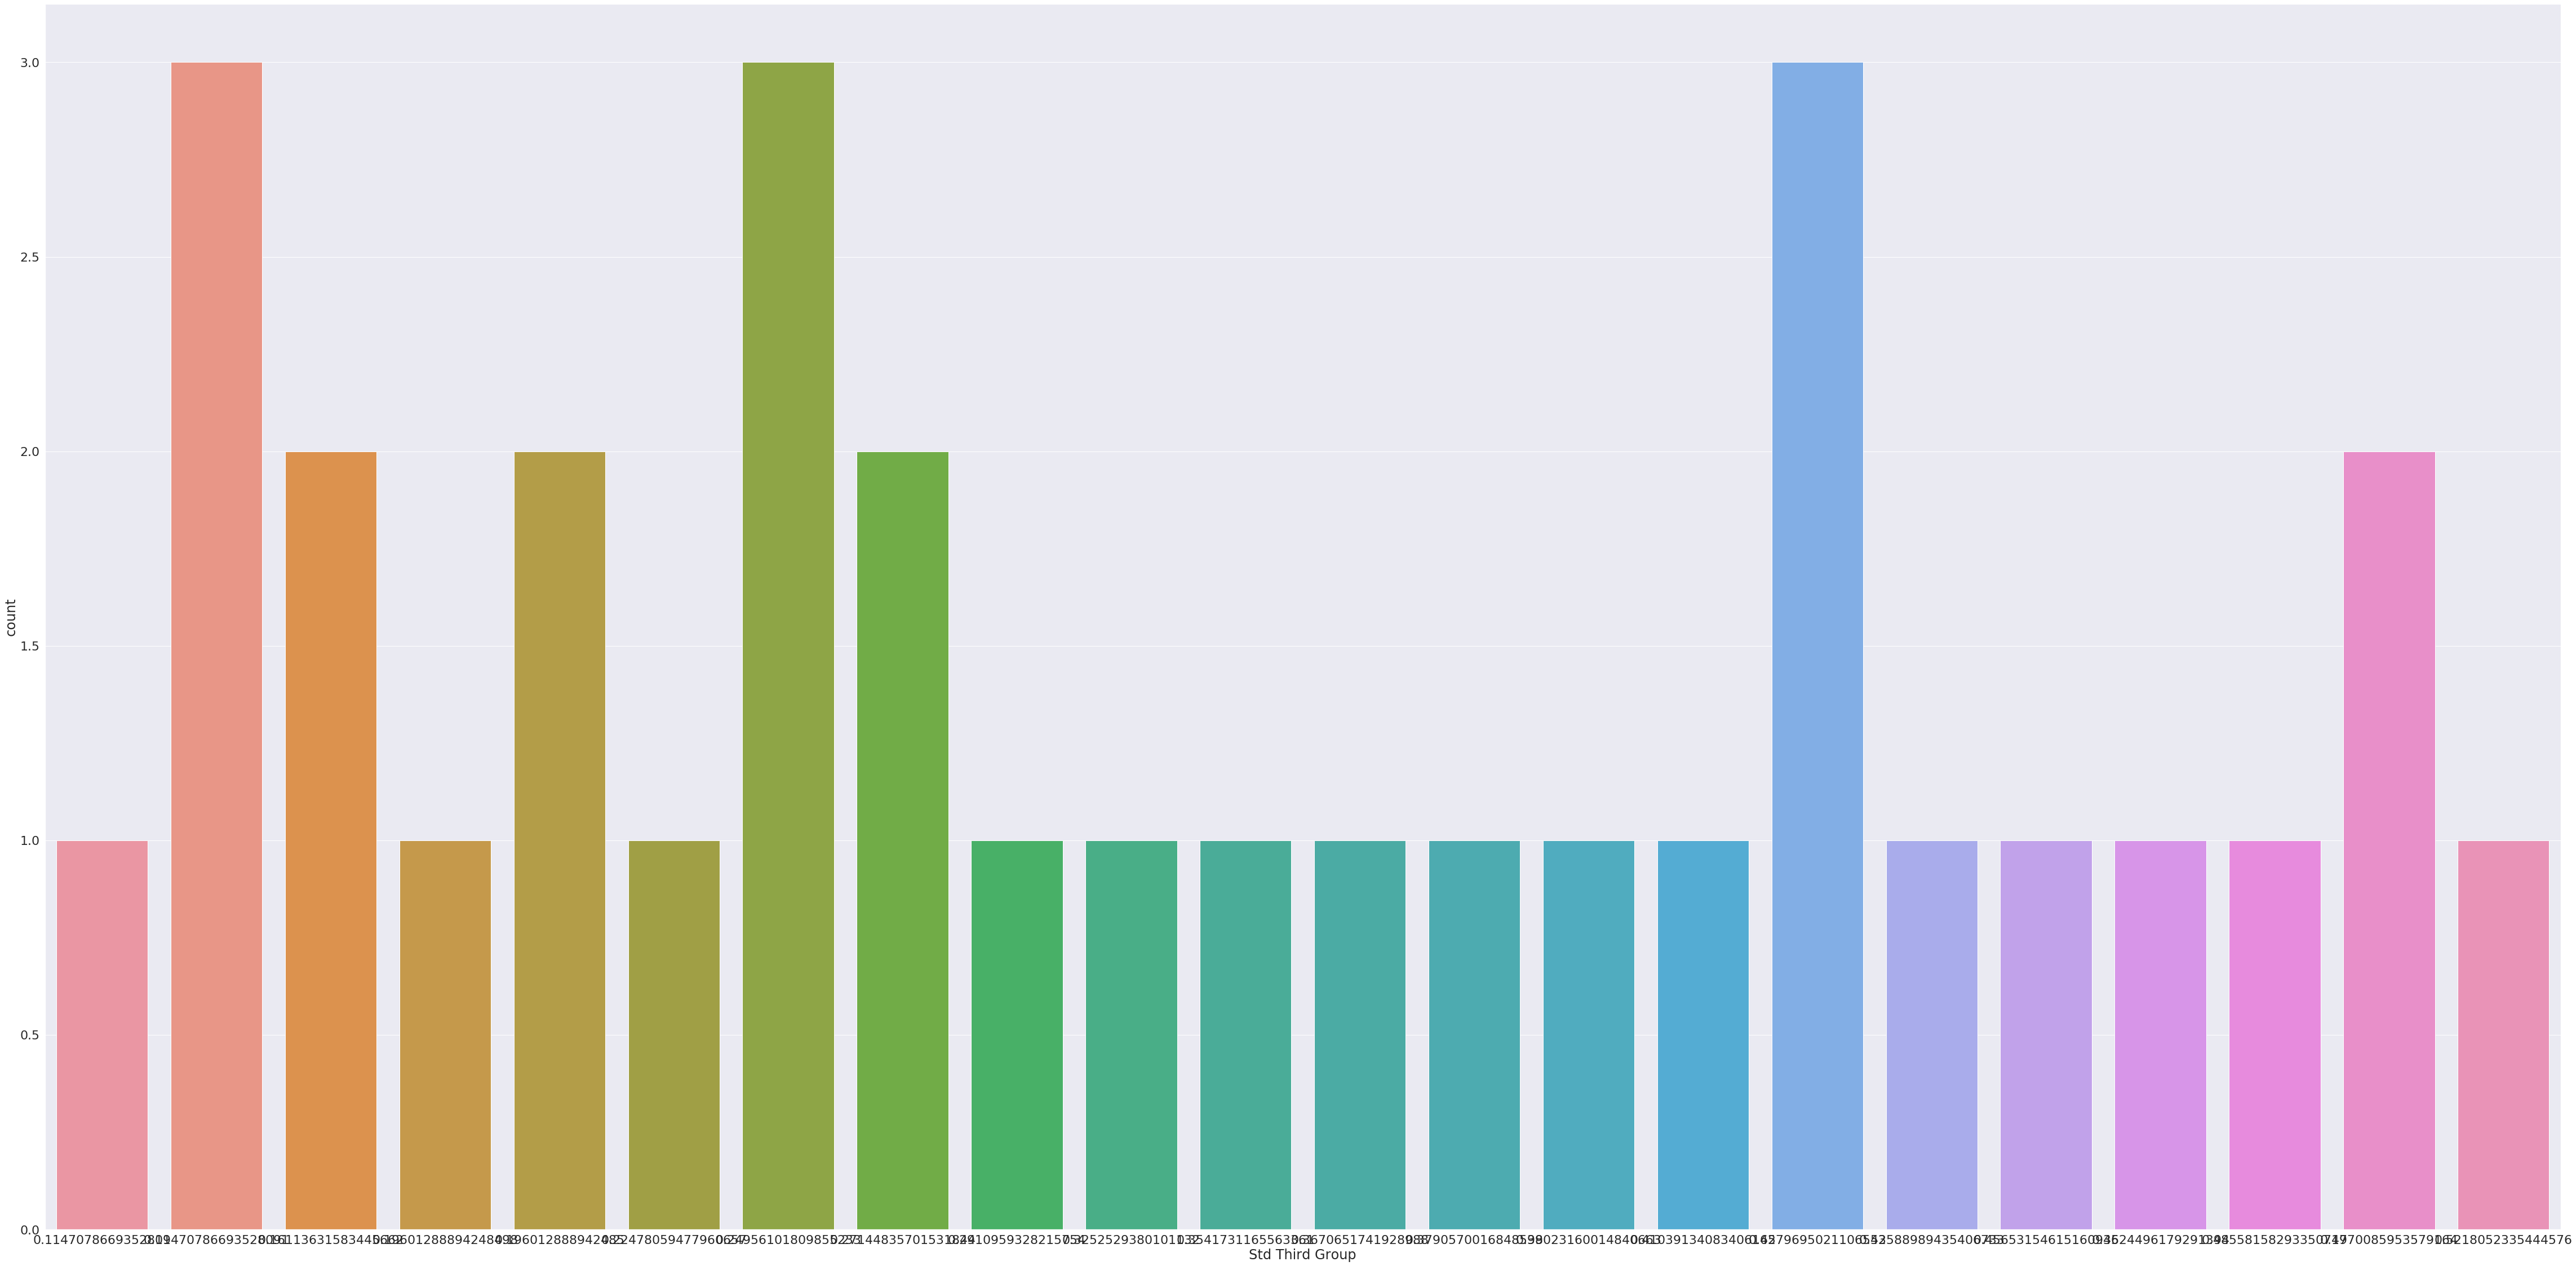

In [95]:
sns.set(font_scale=2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize = (60,10))
ax = fig.add_subplot(1,1, 1)
#sns.countplot()
sns.countplot(dataframe[dataframe['Std First Group']>0]['Std First Group'].drop(index = 'vars.mesh_cells'))
#sns.countplot(dataframe['Std Third Group'].drop(index = 'vars.mesh_cells'))
fig = plt.figure(figsize = (65,10))
ax = fig.add_subplot(1,1, 1)
sns.countplot(dataframe[dataframe['Std Second Group']>0]['Std Second Group'].drop(index = 'vars.mesh_cells'))
sns.set(font_scale=2)
fig = plt.figure(figsize = (80,40))
ax = fig.add_subplot(1,1, 1)
sns.countplot(dataframe[dataframe['Std Third Group']>0]['Std Third Group'].drop(index = 'vars.mesh_cells'))


Text(0, 0.5, 'nb of features')

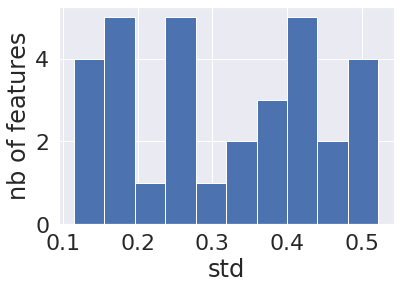

In [96]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
dataframe[dataframe['Std Third Group']>0]['Std Third Group'].drop(index = 'vars.mesh_cells').plot.hist()
ax.set_xlabel('std')
ax.set_ylabel('nb of features')

#ax = fig.add_subplot(1, 1, 1)
#dataframe['Std Second Group'].drop(index = 'vars.mesh_cells').plot.hist()

#ax = fig.add_subplot(1, 1, 1)
#dataframe['Std First Group'].drop(index = 'vars.mesh_cells').plot.hist()
#plt.legend()

Features with non null mean value and null standard deviation describe exactly the groups:

In [97]:
in_first_group = dataframe[(dataframe['Mean First group'] != 0) & (dataframe['Std First Group'] ==0.0)].index

in_second_group = dataframe[(dataframe['Mean Second group'] != 0) & (dataframe['Std Second Group'] ==0.0)].index

in_third_group = dataframe[(dataframe['Mean Third group'] != 0) & (dataframe['Std Third Group'] ==0.0)].index

In [98]:
in_second_group

Index(['vars.dimension', 'ns', 'k_means_pca_int'], dtype='object')

Features with non null mean value and low standard deviation describe features that can be describing the groups:

In [99]:
often_in_first_group = dataframe[(dataframe['Mean First group'] != 0) & (dataframe['Std First Group'] < 0.2)].index

often_in_second_group = dataframe[(dataframe['Mean Second group'] != 0) & (dataframe['Std Second Group'] < 0.2)].index

often_in_third_group = dataframe[(dataframe['Mean Third group'] != 0) & (dataframe['Std Third Group'] < 0.2)].index

In [100]:
in_first_group
in_second_group
in_third_group


Index(['k_means_pca_int'], dtype='object')

In [101]:
for i in in_first_group:
    print('Run first group always is', i)

for i in in_second_group:
    print('Run second group always is', i)
  
for i in in_third_group:
    print('Run third group always is', i)

  


Run first group always is ns
Run first group always is k_means_pca_int
Run second group always is vars.dimension
Run second group always is ns
Run second group always is k_means_pca_int
Run third group always is k_means_pca_int


In [102]:
for feature in dataframe.index:
    #print(feature)
    if feature not in not_first_group:
        pass
        #print('Third group can be', feature)
    else:
        print('First group is never', feature)
print('')
for i in in_first_group:
    print('First group is always ', i)
print('')  
for i in often_in_first_group:
    print('First group is often ', i)
print('') 

for feature in dataframe.index:
    #print(feature)
    if feature not in not_second_group:
        pass
    else:
        print('Second group is never', feature)
print('')
for i in in_second_group:
    print('Second group is always', i)
print('')
for i in often_in_second_group:
    print('Second group is often ', i)
print('') 

for feature in dataframe.index:
    #print(feature)
    if feature not in not_third_group:
        pass
        #print('Third group can be', feature)
    else:
        print('Third group is never', feature)
        
for i in in_third_group:
    print('Third group is always', i)
print('')
for i in often_in_third_group:
    print('Third group is often ', i)
print('') 


First group is never params.smu2
First group is never 1S_C3H8_BFER
First group is never 2S_propane
First group is never AIR
First group is never AIR_QPF_Vortex
First group is never C3H8
First group is never C3H8_22_173_12_FC
First group is never KERO_LUCHE
First group is never N2_qpf
First group is never N2_qpf_poiseuille
First group is never N2_qpf_poiseuille_2D
First group is never 7.4.0
First group is never 7.5.0
First group is never Jameson
First group is never colin_rhou
First group is never colin_rhou_species
First group is never colin_species
First group is never honey
First group is never TTG4A
First group is never sigma
First group is never wale
First group is never euler

First group is always  ns
First group is always  k_means_pca_int

First group is often  C3H8_23_274_10_PP
First group is often  CH4_19_184_11_LU
First group is often  CH4_53_634_0_GRI
First group is often  7.1.0
First group is often  DNS
First group is often  smago
First group is often  ns
First group is oft

In [103]:
print(len(not_third_group))

8


Typing function
- we want to create a classifying function that is looking at the mean value for each feature and the standard deviation.
if std is 0 and mean is 0, the run is definitely not in the group of the feature
if std is (stddev=0, mean=1)  Ces runs  sont toujours :  Wale, ...
(Et ci tu penses que ca a du sens:
-(stddev< threshold, mean<threshold) Ces runs sont rarement :  ...
-(stddev<threshold, mean>threshold)  Ces runs  sont souvent :  ...

In [104]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['First group', 'Second group', 'Third group']
dataframe

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


First group  Second group   Third group
1S_C3H8_BFER                  NaN  0.000000e+00  1.960129e-01
2S_propane                    NaN  0.000000e+00  1.147079e-01
7.1.0                         NaN  0.000000e+00  0.000000e+00
7.2.0                         NaN  4.918981e-01  1.960129e-01
7.3.0                         NaN  5.007300e-01  4.970086e-01
7.4.0                         NaN  0.000000e+00  4.279695e-01
7.5.0                         NaN  3.626321e-01  3.670652e-01
7.6.0                         NaN  1.301889e-01  3.541731e-01
AIR                           NaN  0.000000e+00  4.279695e-01
AIR_QPF_Vortex                NaN  0.000000e+00  1.960129e-01
C3H8                          NaN  3.261450e-01  2.910959e-01
C3H8_22_173_12_FC             NaN  0.000000e+00  2.495610e-01
C3H8_23_274_10_PP             NaN  0.000000e+00  1.147079e-01
CH4                           NaN  5.007300e-01  4.103913e-01
CH4_19_184_11_LU              NaN  0.000000e+00  0.000000e+00
CH4_53_634_0_GRI              NaN  0.000000e+00  0.000000e+00
CH4_LU_19                     NaN  0.000000e+00  0.000000e+00
DNS                           NaN  0.000000e+00  4.970086e-01
Jameson                       NaN  0.000000e+00  4.624496e-01
KERO_LUCHE                    NaN  5.007300e-01  0.000000e+00
LW                            NaN  2.808936e-01  4.358899e-01
LW_FE                         NaN  0.000000e+00  0.000000e+00
N2_qpf                        NaN  0.000000e+00  4.279695e-01
N2_qpf_poiseuille             NaN  0.000000e+00  1.611363e-01
N2_qpf_poiseuille_2D          NaN  0.000000e+00  1.611363e-01
TTG4A                         NaN  0.000000e+00  2.714484e-01
TTGC                          NaN  2.808936e-01  3.790570e-01
clusters                      NaN           NaN           NaN
colin                         NaN  4.391693e-01  4.855816e-01
colin_rhou                    NaN  0.000000e+00  2.247806e-01
colin_rhou_species            NaN  0.000000e+00  2.714484e-01
colin_species                 NaN  4.391693e-01  0.000000e+00
euler                         NaN  0.000000e+00  2.495610e-01
honey                         NaN  0.000000e+00  1.147079e-01
k_means_pca                   NaN           NaN           NaN
k_means_pca_int               NaN  0.000000e+00  0.000000e+00
no visc model                 NaN  0.000000e+00  3.902316e-01
ns                            NaN  0.000000e+00  2.495610e-01
params.smu2                   NaN  4.074123e-01  0.000000e+00
sigma                         NaN  4.290721e-01  3.252529e-01
smago                         NaN  2.215719e-01  4.565315e-01
vars.dimension                NaN  0.000000e+00  5.218052e-01
vars.mesh_cells               NaN  1.476375e+07  6.820168e+06
wale                          NaN  3.928050e-01  1.147079e-01

In [105]:
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std()

params.smu2             4.074123e-01
vars.dimension          0.000000e+00
vars.mesh_cells         1.476375e+07
1S_C3H8_BFER            0.000000e+00
2S_propane              0.000000e+00
AIR                     0.000000e+00
AIR_QPF_Vortex          0.000000e+00
C3H8                    3.261450e-01
C3H8_22_173_12_FC       0.000000e+00
C3H8_23_274_10_PP       0.000000e+00
CH4                     5.007300e-01
CH4_19_184_11_LU        0.000000e+00
CH4_53_634_0_GRI        0.000000e+00
CH4_LU_19               0.000000e+00
KERO_LUCHE              5.007300e-01
N2_qpf                  0.000000e+00
N2_qpf_poiseuille       0.000000e+00
N2_qpf_poiseuille_2D    0.000000e+00
7.1.0                   0.000000e+00
7.2.0                   4.918981e-01
7.3.0                   5.007300e-01
7.4.0                   0.000000e+00
7.5.0                   3.626321e-01
7.6.0                   1.301889e-01
Jameson                 0.000000e+00
colin                   4.391693e-01
colin_rhou              0.000000e+00
c

In [106]:
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()


params.smu2             0.000000e+00
vars.dimension          5.218052e-01
vars.mesh_cells         6.820168e+06
1S_C3H8_BFER            1.960129e-01
2S_propane              1.147079e-01
AIR                     4.279695e-01
AIR_QPF_Vortex          1.960129e-01
C3H8                    2.910959e-01
C3H8_22_173_12_FC       2.495610e-01
C3H8_23_274_10_PP       1.147079e-01
CH4                     4.103913e-01
CH4_19_184_11_LU        0.000000e+00
CH4_53_634_0_GRI        0.000000e+00
CH4_LU_19               0.000000e+00
KERO_LUCHE              0.000000e+00
N2_qpf                  4.279695e-01
N2_qpf_poiseuille       1.611363e-01
N2_qpf_poiseuille_2D    1.611363e-01
7.1.0                   0.000000e+00
7.2.0                   1.960129e-01
7.3.0                   4.970086e-01
7.4.0                   4.279695e-01
7.5.0                   3.670652e-01
7.6.0                   3.541731e-01
Jameson                 4.624496e-01
colin                   4.855816e-01
colin_rhou              2.247806e-01
c

In [107]:
df_comp2.groupby('k_means_pca').mean()

params.smu2  vars.dimension  vars.mesh_cells  1S_C3H8_BFER  \
k_means_pca                                                                
First Group      0.000000        2.048780     1.575570e+06      0.000000   
Second Group     0.847458        3.000000     3.150860e+07      0.000000   
Third Group      0.000000        2.315789     1.970881e+06      0.039474   

              2S_propane       AIR  AIR_QPF_Vortex      C3H8  \
k_means_pca                                                    
First Group     0.000000  0.000000        0.000000  0.000000   
Second Group    0.000000  0.000000        0.000000  0.118644   
Third Group     0.013158  0.236842        0.039474  0.092105   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  ...     LW_FE     TTG4A  \
k_means_pca                                         ...                       
First Group            0.000000           0.024390  ...  0.682927  0.000000   
Second Group           0.000000           0.000000  ...  0.000000  0.000000   
Third Group            0.065789           0.013158  ...  0.000000  0.078947   

                  TTGC       DNS     sigma     smago      wale     euler  \
k_means_pca                                                                
First Group   0.121951  0.975610  0.000000  0.024390  0.000000  0.000000   
Second Group  0.915254  0.000000  0.762712  0.050847  0.186441  0.000000   
Third Group   0.171053  0.578947  0.118421  0.289474  0.013158  0.065789   

                    ns  k_means_pca_int  
k_means_pca                              
First Group   1.000000              1.0  
Second Group  1.000000              2.0  
Third Group   0.934211              3.0  

[3 rows x 42 columns]

In [108]:
df_comp2.groupby('k_means_pca').std()

params.smu2  vars.dimension  vars.mesh_cells  1S_C3H8_BFER  \
k_means_pca                                                                
First Group      0.000000        0.384137     3.860761e+06      0.000000   
Second Group     0.407412        0.000000     1.476375e+07      0.000000   
Third Group      0.000000        0.521805     6.820168e+06      0.196013   

              2S_propane      AIR  AIR_QPF_Vortex      C3H8  \
k_means_pca                                                   
First Group     0.000000  0.00000        0.000000  0.000000   
Second Group    0.000000  0.00000        0.000000  0.326145   
Third Group     0.114708  0.42797        0.196013  0.291096   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  ...     LW_FE     TTG4A  \
k_means_pca                                         ...                       
First Group            0.000000           0.156174  ...  0.471117  0.000000   
Second Group           0.000000           0.000000  ...  0.000000  0.000000   
Third Group            0.249561           0.114708  ...  0.000000  0.271448   

                  TTGC       DNS     sigma     smago      wale     euler  \
k_means_pca                                                                
First Group   0.331295  0.156174  0.000000  0.156174  0.000000  0.000000   
Second Group  0.280894  0.000000  0.429072  0.221572  0.392805  0.000000   
Third Group   0.379057  0.497009  0.325253  0.456532  0.114708  0.249561   

                    ns  k_means_pca_int  
k_means_pca                              
First Group   0.000000              0.0  
Second Group  0.000000              0.0  
Third Group   0.249561              0.0  

[3 rows x 42 columns]

In [109]:
df_comp2.head()

params.smu2  vars.dimension  vars.mesh_cells  1S_C3H8_BFER  2S_propane  \
0          1.0               3       45486233.0             0           0   
1          0.0               2          48450.0             0           0   
2          1.0               3       45469910.0             0           0   
3          0.0               3       19616196.0             0           0   
4          0.0               3          47491.0             0           0   

   AIR  AIR_QPF_Vortex  C3H8  C3H8_22_173_12_FC  C3H8_23_274_10_PP  ...  TTGC  \
0    0               0     0                  0                  0  ...     1   
1    1               0     0                  0                  0  ...     0   
2    0               0     0                  0                  0  ...     1   
3    0               0     1                  0                  0  ...     1   
4    1               0     0                  0                  0  ...     0   

   DNS  sigma  smago  wale  euler  ns   k_means_pca      clusters  \
0    0      1      0     0      0   1  Second Group  Second Group   
1    1      0      0     0      0   1   Third Group   Third Group   
2    0      0      0     1      0   1  Second Group  Second Group   
3    0      0      0     1      0   1  Second Group  Second Group   
4    0      1      0     0      0   1   Third Group   Third Group   

   k_means_pca_int  
0                2  
1                3  
2                2  
3                2  
4                3  

[5 rows x 44 columns]

The PCA gives us a hint of how to plot in 2D the plots.
so we know that we can plot runs by colin_species and wale, maybe vars.dimension and ncell group.
so we can also make a pairplot regarding these variables.

## Kmeans with 3 clusters with highlight of converged/not converged

In [110]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 0 1 1 0 1 1 0 1 0 2 1 2 2 1 1 2 0 1 2 1 0 1 0 0 2 0 0 2 0 0 1 2 1 0 0 1
 0 1 1 0 0 1 2 1 2 0 2 2 2 2 0 1 0 2 1 2 2 2 1 1 0 0 0 1 0 0 0 1 1 2 0 0 0
 0 2 2 0 0 2 0 1 0 0 2 0 0 1 0 1 0 0 2 1 2 0 1 0 1 1 2 2 1 1 1 1 1 1 2 0 2
 0 2 0 0 0 2 0 1 0 0 0 1 1 2 1 1 1 0 2 0 1 0 0 0 2 0 0 1 1 1 0 2 0 2 1 1 1
 1 1 2 0 1 2 0 0 1 1 0 0 0 1 0 0 1 1 2 0 0 0 2 1 2 1 0 2]


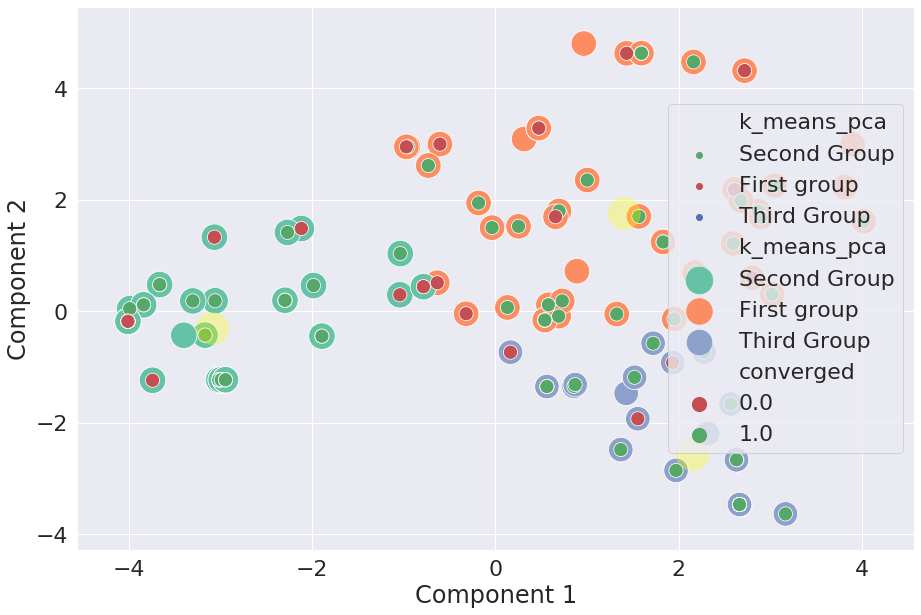

In [111]:
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,10))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
                palette = ['g', 'r', 'b'], alpha = 0.6)

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'],
                sizes= (600,700), palette="Set2")

sns.scatterplot(x, y, hue = df_pca_c['converged'], 
                size = df_pca_c['converged'],
               sizes = (200,200), palette = ['r', 'g'])

plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)


## PCA with 4 components

We know that a PCA with 4 components should optimize the standard deviation kept in the dimension reduction.

In [112]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp4 = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp4.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

scores_pca stores the projections of each run in the new frame system.
PCA_components stores the linear coefficients of each PCA component of the original features.

In [113]:
pca4 = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
pca4['PCA components'] = [0, 1, 2, 3]
pca4.set_index('PCA components')
pca4['KERO_LUCHE']

0    0.243432
1    0.015277
2    0.188844
3    0.016608
Name: KERO_LUCHE, dtype: float64

In [114]:
scores_pca

array([[-4.00834276, -0.17817134,  1.62291539, -1.06860309],
       [ 2.59571888,  1.21775397,  0.4828293 , -0.22812859],
       [-3.83743169,  0.11804082,  2.24658279,  3.35680495],
       [-1.98366251,  0.46384296, -0.12602739,  5.40518397],
       [ 0.31434616,  3.09185552, -0.5579701 , -1.37055447],
       [-4.00834276, -0.17817134,  1.62291539, -1.06860309],
       [-3.01704615, -1.22676173, -0.59876805, -1.78792744],
       [ 2.17549301,  0.69398197, -0.76512523,  0.26948606],
       [-3.01704615, -1.22676173, -0.59876805, -1.78792744],
       [ 0.4741962 ,  3.28671347, -1.96399149, -1.06003103],
       [ 2.66498627, -3.46360924, -0.95679031,  0.16749504],
       [-3.05761135,  0.19028929,  0.48409642,  6.57207133],
       [ 1.72178206, -0.5713987 ,  0.32574956, -0.27355855],
       [ 2.66498627, -3.46360924, -0.95679031,  0.16749504],
       [-2.2670173 ,  1.41623348, -0.40989417,  3.07342836],
       [-3.30037627,  0.18752361,  0.56412356,  6.60321031],
       [ 1.72184117, -0.

for the first component of PCA, we can see that the most important features are params.ncell_group, params.smu2, vars.MPI_processes, vars.dimension, vars.nodes and AIR.

In [115]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[-4.00834276  2.59571888 -3.83743169 -1.98366251  0.31434616 -4.00834276
 -3.01704615  2.17549301 -3.01704615  0.4741962   2.66498627 -3.05761135
  1.72178206  2.66498627 -2.2670173  -3.30037627  1.72184117  0.54007993
 -4.00834276  1.42811113 -2.99064951  0.54007993 -4.00802094  1.32491707
  1.56603689  2.57123878  2.68135143  1.95187917  2.66498627  1.59418043
  0.69562334 -3.1670301   0.56293947 -3.1670301   1.59418043  0.96555698
 -3.98875095 -0.18236562 -4.00834276 -3.01704615 -0.97022451  2.60999967
 -1.03682314  3.16574007 -3.06461788  1.9719801  -0.63310798  2.66498627
  0.85844373  2.31798678  2.66498627  2.80226584 -2.99064951  0.57945992
  1.9719801  -2.29483181  0.87126523  2.66498627  2.66498627 -2.99064951
 -0.78442724  3.8137371   2.89969857 -0.95271977 -4.00802094  0.54007993
  0.7306964   0.57945992 -3.66201426 -1.89220222  2.66498627  2.71955022
  2.16270431  1.95187917  2.16270431  0.56293947  2.63573153  3.02080225
  1.43353585  2.27868707 -0.97022451 -2.94462372  1

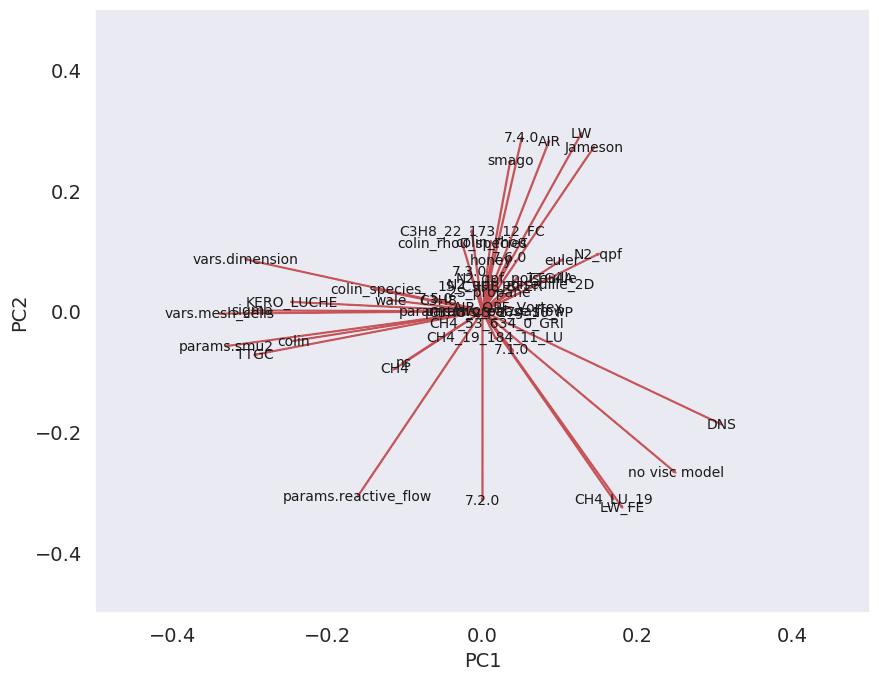

In [116]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [117]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,2] # projection on PC1
    print(x)
    y = scores_pca[:,3] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,2], coeff[i,3], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,2]*1.01, coeff[i,3]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(3), size=14)
    plt.ylabel("PC{}".format(4), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 1.62291539  0.4828293   2.24658279 -0.12602739 -0.5579701   1.62291539
 -0.59876805 -0.76512523 -0.59876805 -1.96399149 -0.95679031  0.48409642
  0.32574956 -0.95679031 -0.40989417  0.56412356  0.32573008 -0.93576788
  1.62291539  1.1158347  -0.60746967 -0.93576788  1.62280931 -0.1277007
  0.26842767 -1.42857483  2.30888621  2.67152171 -0.95679031 -2.00508084
 -2.80974206  0.70383215 -1.25597128  0.70383215 -2.00508084 -4.36742909
  1.19923594 -2.65331894  1.62291539 -0.59876805 -3.49293756  1.681007
 -2.1763304  -0.83329166  1.77342411 -0.90784669  0.06226906 -0.95679031
 -1.35338387 -0.5905153  -0.95679031  2.03415956 -0.60746967 -0.69948285
 -0.90784669  0.23264714  0.96315461 -0.95679031 -0.95679031 -0.60746967
 -0.9850778   3.63548539  3.7660171  -3.49870797  1.62280931 -0.93576788
  0.3478913  -0.69948285  1.9401407  -0.55389087 -0.95679031 -1.70357029
 -1.85625038  2.67152171 -1.85625038 -1.25597128  0.30601167  3.49122806
 -1.95212456  0.47841017 -3.49293756 -0.62264201 -2.00

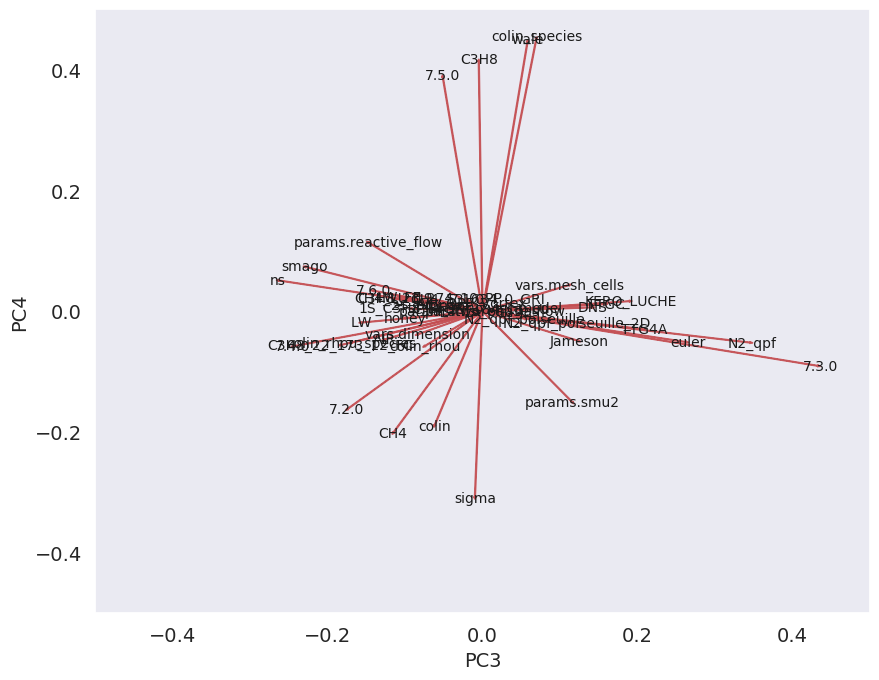

In [118]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [119]:
df_comp4.head()

params.reactive_flow  params.real_gas  params.smu2  params.two_phase_flow  \
0                     1              0.0          1.0                    0.0   
1                     0              0.0          0.0                    0.0   
2                     1              0.0          1.0                    0.0   
3                     1              0.0          0.0                    0.0   
4                     0              0.0          0.0                    0.0   

   vars.dimension  vars.mesh_cells  1S_C3H8_BFER  2S_propane  AIR  \
0               3       45486233.0             0           0    0   
1               2          48450.0             0           0    1   
2               3       45469910.0             0           0    0   
3               3       19616196.0             0           0    0   
4               3          47491.0             0           0    1   

   AIR_QPF_Vortex  ...  DNS  sigma  smago  wale  euler  ns  Component 1  \
0               0  ...    0      1      0     0      0   1    -4.008343   
1               0  ...    1      0      0     0      0   1     2.595719   
2               0  ...    0      0      0     1      0   1    -3.837432   
3               0  ...    0      0      0     1      0   1    -1.983663   
4               0  ...    0      1      0     0      0   1     0.314346   

   Component 2  Component 3  Component 4  
0    -0.178171     1.622915    -1.068603  
1     1.217754     0.482829    -0.228129  
2     0.118041     2.246583     3.356805  
3     0.463843    -0.126027     5.405184  
4     3.091856    -0.557970    -1.370554  

[5 rows x 48 columns]

In [120]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp4['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[2 0 2 1 1 2 2 0 2 1 0 1 0 0 1 1 0 1 2 0 2 1 2 0 0 0 0 0 0 1 1 2 0 2 1 1 2
 1 2 2 1 0 1 0 2 0 1 0 0 0 0 0 2 1 0 1 0 0 0 2 1 0 0 1 2 1 0 1 2 2 0 1 1 0
 1 0 0 0 1 0 1 2 1 0 0 1 0 2 1 2 1 1 0 2 0 0 2 0 2 2 0 0 2 2 2 2 1 2 0 0 0
 0 0 1 1 1 0 1 2 0 1 0 2 2 0 2 2 2 0 0 0 2 0 0 1 0 1 0 2 1 1 1 0 1 0 2 2 2
 2 2 0 0 1 0 0 1 2 2 0 1 0 2 0 1 1 2 0 1 0 1 0 1 0 2 0 0]


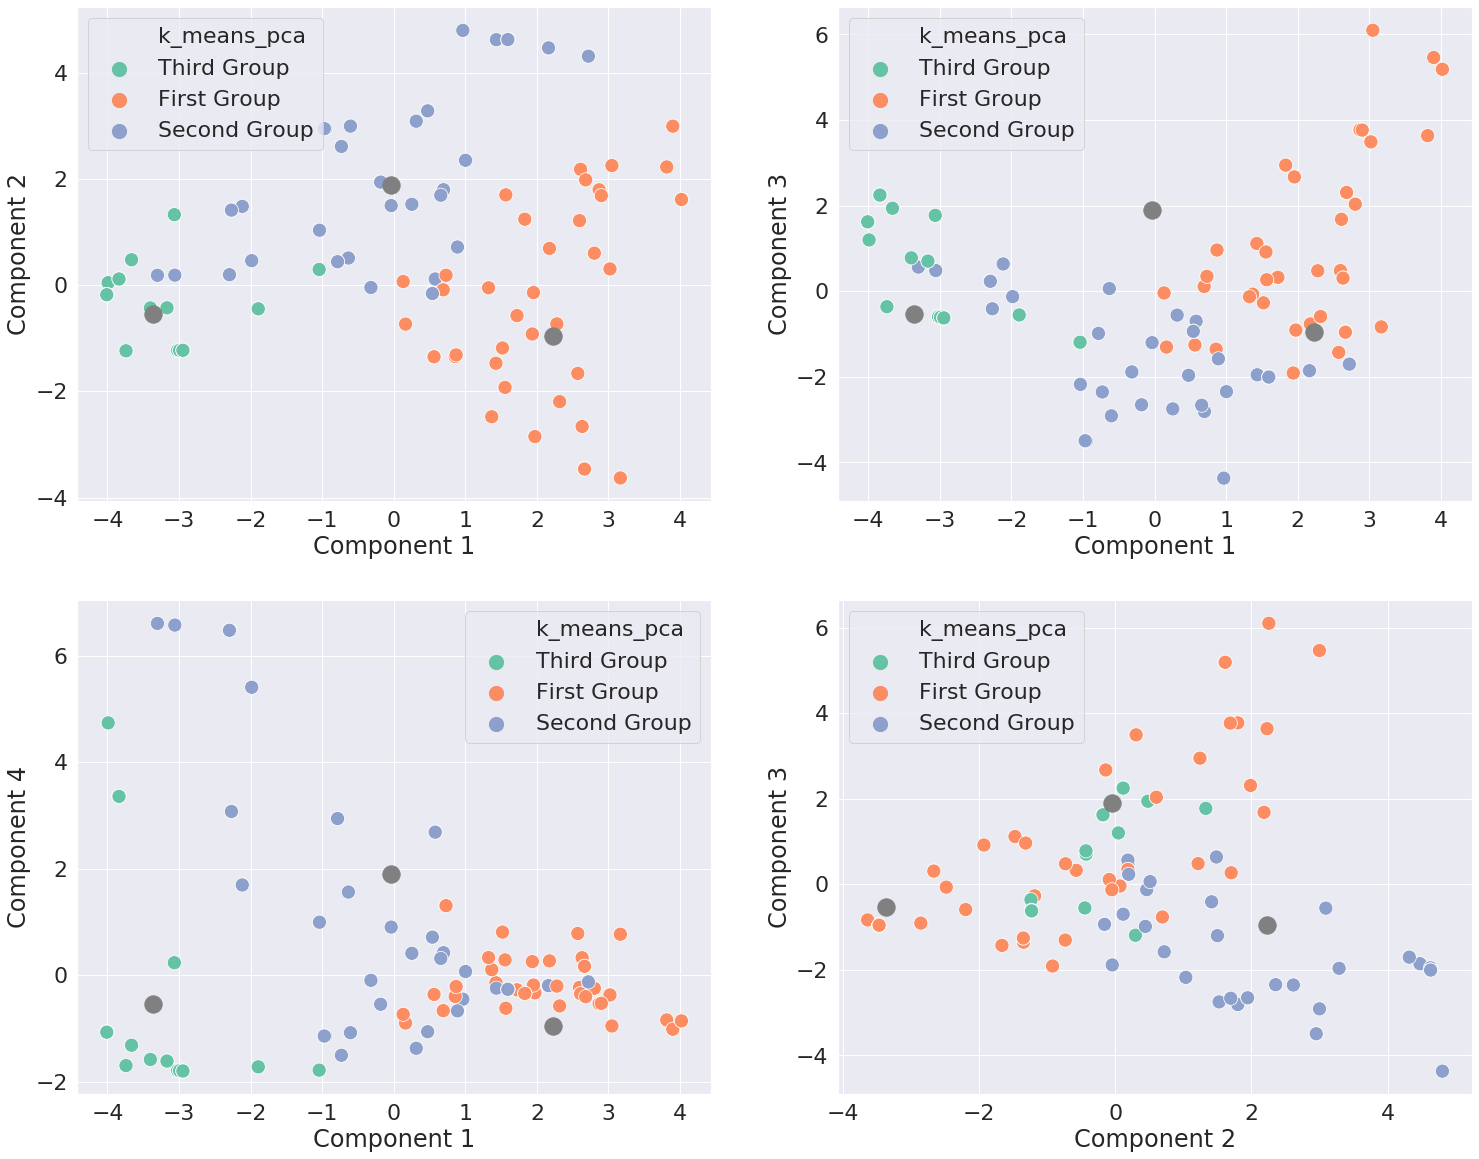

In [121]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp4['k_means_pca'] = df_comp4['k_means_pca'].map({0: 'First Group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp4['Component 1']
y = df_comp4['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp4['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp4['k_means_pca'],
                size = df_comp4['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp4['Component 1']
y = df_comp4['Component 3']

sns.scatterplot(x, y, hue = df_comp4['k_means_pca'],
                size = df_comp4['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp4['Component 1']
y = df_comp4['Component 4']

sns.scatterplot(x, y, hue = df_comp4['k_means_pca'], 
                size = df_comp4['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp4['Component 2']
y = df_comp4['Component 3']

sns.scatterplot(x, y, hue = df_comp4['k_means_pca'], size = df_comp4['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

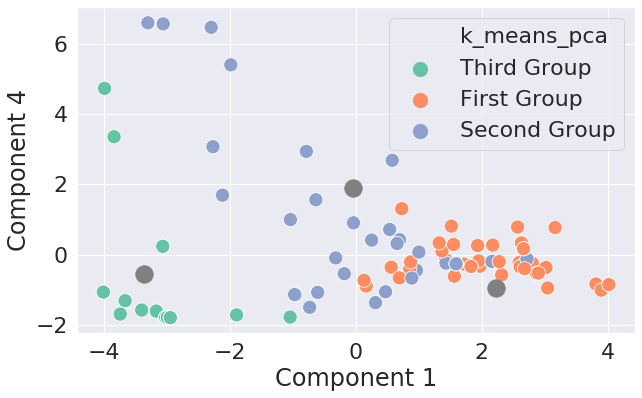

In [122]:
fig = plt.figure(figsize = (10,6))
x = df_comp4['Component 1']
y = df_comp4['Component 4']

sns.scatterplot(x, y, hue = df_comp4['k_means_pca'], size = df_comp4['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

In [123]:
df_comp3 = df_comp4.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp3.groupby('k_means_pca').mean()

params.smu2  vars.dimension  vars.mesh_cells  1S_C3H8_BFER  \
k_means_pca                                                                
First Group      0.000000        2.093333     8.677516e+05      0.000000   
Second Group     0.057692        2.557692     8.964199e+06      0.057692   
Third Group      0.959184        3.000000     3.147292e+07      0.000000   

              2S_propane       AIR  AIR_QPF_Vortex      C3H8  \
k_means_pca                                                    
First Group     0.000000  0.040000            0.04  0.026667   
Second Group    0.019231  0.288462            0.00  0.230769   
Third Group     0.000000  0.000000            0.00  0.000000   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  ...        LW     LW_FE  \
k_means_pca                                         ...                       
First Group            0.000000           0.013333  ...  0.373333  0.373333   
Second Group           0.096154           0.019231  ...  0.769231  0.000000   
Third Group            0.000000           0.000000  ...  0.040816  0.000000   

              TTG4A      TTGC       DNS     sigma     smago      wale  \
k_means_pca                                                             
First Group    0.08  0.173333  0.986667  0.000000  0.013333  0.000000   
Second Group   0.00  0.230769  0.192308  0.173077  0.480769  0.153846   
Third Group    0.00  0.959184  0.000000  0.918367  0.000000  0.081633   

                 euler        ns  
k_means_pca                       
First Group   0.066667  0.933333  
Second Group  0.000000  1.000000  
Third Group   0.000000  1.000000  

[3 rows x 41 columns]

In [124]:
df_comp3.groupby('k_means_pca').std()

params.smu2  vars.dimension  vars.mesh_cells  1S_C3H8_BFER  \
k_means_pca                                                                
First Group      0.000000        0.373925     2.944446e+06      0.000000   
Second Group     0.235435        0.574404     1.572155e+07      0.235435   
Third Group      0.285714        0.000000     1.420085e+07      0.000000   

              2S_propane       AIR  AIR_QPF_Vortex      C3H8  \
k_means_pca                                                    
First Group     0.000000  0.197279        0.197279  0.162192   
Second Group    0.138675  0.457467        0.000000  0.425436   
Third Group     0.000000  0.000000        0.000000  0.000000   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  ...        LW     LW_FE  \
k_means_pca                                         ...                       
First Group            0.000000           0.115470  ...  0.486947  0.486947   
Second Group           0.297678           0.138675  ...  0.425436  0.000000   
Third Group            0.000000           0.000000  ...  0.199915  0.000000   

                TTG4A      TTGC       DNS     sigma     smago      wale  \
k_means_pca                                                               
First Group   0.27312  0.381084  0.115470  0.000000  0.115470  0.000000   
Second Group  0.00000  0.425436  0.397959  0.382005  0.504505  0.364321   
Third Group   0.00000  0.199915  0.000000  0.276642  0.000000  0.276642   

                 euler        ns  
k_means_pca                       
First Group   0.251124  0.251124  
Second Group  0.000000  0.000000  
Third Group   0.000000  0.000000  

[3 rows x 41 columns]

In [125]:
dataframe = pd.concat([df_comp3[df_comp3['k_means_pca'] == 'First Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'First Group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Second group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.mesh_cells          867751.626667     2.944446e+06       8.964199e+06   
vars.dimension                2.093333     3.739249e-01       2.557692e+00   
ns                            0.933333     2.511236e-01       1.000000e+00   
LW                            0.373333     4.869467e-01       7.692308e-01   
smago                         0.013333     1.154701e-01       4.807692e-01   
colin                         0.146667     3.561556e-01       4.038462e-01   
7.5.0                         0.000000     0.000000e+00       3.846154e-01   
7.4.0                         0.000000     0.000000e+00       3.461538e-01   
AIR                           0.040000     1.972788e-01       2.884615e-01   
TTGC                          0.173333     3.810843e-01       2.307692e-01   
CH4                           0.160000     3.690748e-01       2.307692e-01   
C3H8                          0.026667     1.621922e-01       2.307692e-01   
DNS                           0.986667     1.154701e-01       1.923077e-01   
colin_species                 0.000000     0.000000e+00       1.923077e-01   
Jameson                       0.173333     3.810843e-01       1.923077e-01   
7.6.0                         0.066667     2.511236e-01       1.730769e-01   
sigma                         0.000000     0.000000e+00       1.730769e-01   
wale                          0.000000     0.000000e+00       1.538462e-01   
colin_rhou_species            0.000000     0.000000e+00       1.153846e-01   
C3H8_22_173_12_FC             0.000000     0.000000e+00       9.615385e-02   
colin_rhou                    0.000000     0.000000e+00       7.692308e-02   
params.smu2                   0.000000     0.000000e+00       5.769231e-02   
7.3.0                         0.520000     5.029642e-01       5.769231e-02   
KERO_LUCHE                    0.000000     0.000000e+00       5.769231e-02   
1S_C3H8_BFER                  0.000000     0.000000e+00       5.769231e-02   
7.2.0                         0.400000     4.931970e-01       3.846154e-02   
honey                         0.000000     0.000000e+00       1.923077e-02   
C3H8_23_274_10_PP             0.013333     1.154701e-01       1.923077e-02   
2S_propane                    0.000000     0.000000e+00       1.923077e-02   
N2_qpf                        0.240000     4.299591e-01       0.000000e+00   
N2_qpf_poiseuille             0.026667     1.621922e-01       0.000000e+00   
CH4_LU_19                     0.400000     4.931970e-01       0.000000e+00   
no visc model                 0.680000     4.696174e-01       0.000000e+00   
7.1.0                         0.013333     1.154701e-01       0.000000e+00   
LW_FE                         0.373333     4.869467e-01       0.000000e+00   
TTG4A                         0.080000     2.731201e-01       0.000000e+00   
CH4_19_184_11_LU              0.013333     1.154701e-01       0.000000e+00   
AIR_QPF_Vortex                0.040000     1.972788e-01       0.000000e+00   
N2_qpf_poiseuille_2D          0.026667     1.621922e-01       0.000000e+00   
euler                         0.066667     2.511236e-01       0.000000e+00   
CH4_53_634_0_GRI              0.013333     1.154701e-01       0.000000e+00   

                      Std Second Group  Mean Third group  Std Third Group  
vars.mesh_cells           1.572155e+07      3.147292e+07     1.420085e+07  
vars.dimension            5.744038e-01      3.000000e+00     0.000000e+00  
ns                        0.000000e+00      1.000000e+00     0.000000e+00  
LW                        4.254356e-01      4.081633e-02     1.999149e-01  
smago                     5.045046e-01      0.000000e+00     0.000000e+00  
colin                     4.954545e-01      8.979592e-01     3.058389e-01  
7.5.0                     4.912508e-01      2.040816e-02     1.428571e-01  
7.4.0                     4.803845e-01      0.000000e+00     0.000000e+00  
AIR                       4.574670e-01      0.000000e+00     


# Same study with 4 clusters: 

In [126]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp6 = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp6.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scores_pca)
df_comp6['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 3 1 1 2 1 1 0 1 2 0 1 0 0 1 1 0 0 1 0 1 0 1 0 3 0 3 3 0 2 2 1 0 1 2 2 1
 2 1 1 2 3 2 0 1 0 1 0 0 0 0 3 1 0 0 1 0 0 0 1 1 3 3 2 1 0 0 0 1 1 0 2 2 3
 2 0 0 3 2 0 2 1 2 0 0 2 3 1 2 1 0 2 0 1 0 3 1 3 1 1 0 0 1 1 1 1 1 1 0 3 0
 3 0 0 2 0 0 2 1 3 2 0 1 1 0 1 1 1 3 0 3 1 3 3 2 0 2 0 1 1 1 2 0 2 0 1 1 1
 1 1 0 3 1 0 0 2 1 1 3 2 3 1 0 2 1 1 0 0 3 0 0 1 0 1 3 0]


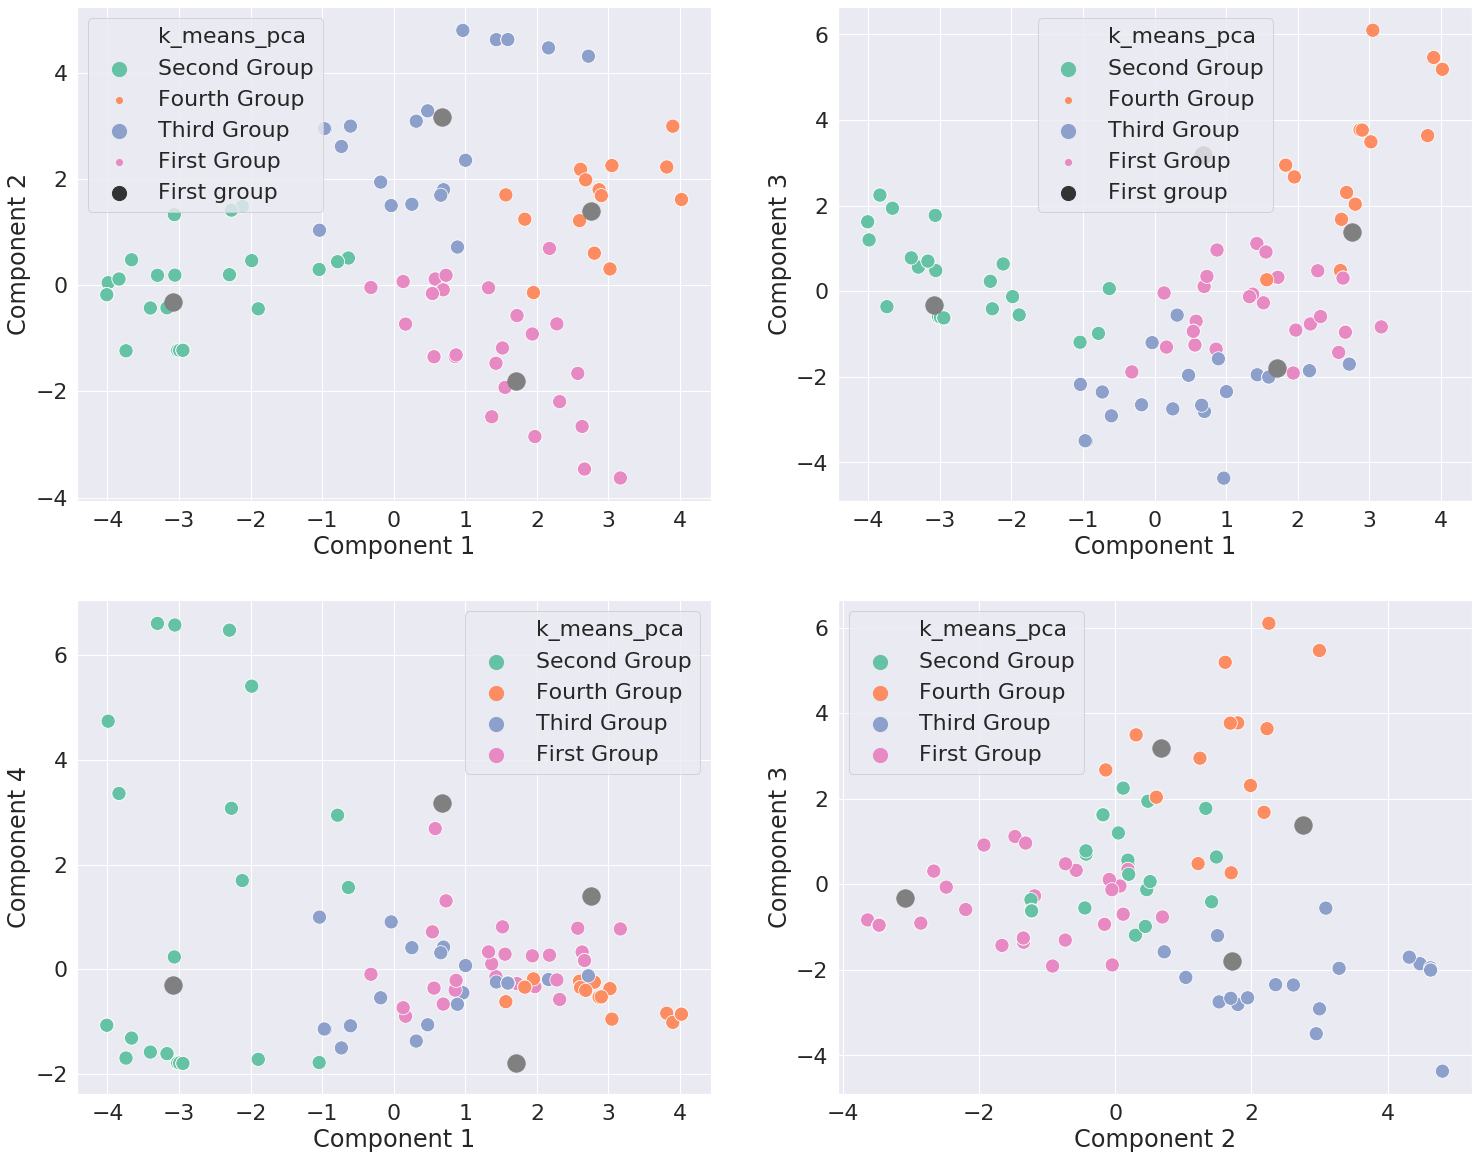

In [127]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp6['k_means_pca'] = df_comp6['k_means_pca'].map({0: 'First Group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group', 
                                                     3: 'Fourth Group'})

fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp6['Component 1']
y = df_comp6['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp6['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp6['Component 1']
y = df_comp6['Component 3']

sns.scatterplot(x, y, hue = df_comp6['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp6['Component 1']
y = df_comp6['Component 4']

sns.scatterplot(x, y, hue = df_comp6['k_means_pca'], 
                size = df_comp6['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp6['Component 2']
y = df_comp6['Component 3']

sns.scatterplot(x, y, hue = df_comp6['k_means_pca'], size = df_comp6['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

In [128]:
df_temp1_k4 = df_comp6.groupby('k_means_pca').sum()[dummies_LES_model.columns]
df_temp1_k4

DNS  sigma  smago  wale
k_means_pca                          
First Group    58      0      2     0
Fourth Group   25      0      0     0
Second Group    0     45      6    11
Third Group     1      9     18     1

In [129]:
df_temp2_k4 = df_comp6.groupby('k_means_pca').sum()[dummies_mixturename.columns]
df_temp2_k4

1S_C3H8_BFER  2S_propane  AIR  AIR_QPF_Vortex  C3H8  \
k_means_pca                                                         
First Group              1           0    0               3     4   
Fourth Group             0           0    3               0     0   
Second Group             0           0    0               0    10   
Third Group              2           1   15               0     0   

              C3H8_22_173_12_FC  C3H8_23_274_10_PP  CH4  CH4_19_184_11_LU  \
k_means_pca                                                                 
First Group                   0                  1   19                 1   
Fourth Group                  0                  0    0                 0   
Second Group                  0                  0   26                 0   
Third Group                   5                  1    5                 0   

              CH4_53_634_0_GRI  CH4_LU_19  KERO_LUCHE  N2_qpf  \
k_means_pca                                                     
First Group                  1         30           0       0   
Fourth Group                 0          0           0      18   
Second Group                 0          0          26       0   
Third Group                  0          0           0       0   

              N2_qpf_poiseuille  N2_qpf_poiseuille_2D  
k_means_pca                                            
First Group                   0                     0  
Fourth Group                  2                     2  
Second Group                  0                     0  
Third Group                   0                     0

In [130]:
df_temp3_k4 = df_comp6.groupby('k_means_pca').sum()[dummies_viscoartif.columns]
df_temp3_k4

Jameson  colin  colin_rhou  colin_rhou_species  colin_species  \
k_means_pca                                                                   
First Group         0     20           0                   0              0   
Fourth Group       13      1           0                   0              0   
Second Group        0     47           0                   0             15   
Third Group        10      8           4                   6              0   

              honey  no visc model  
k_means_pca                         
First Group       0             40  
Fourth Group      0             11  
Second Group      0              0  
Third Group       1              0

In [131]:
dataframe = pd.concat([df_comp6[df_comp6['k_means_pca'] == 'First group'].mean(), 
                       df_comp6[df_comp6['k_means_pca'] == 'First group'].std(),
                       df_comp6[df_comp6['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp6[df_comp6['k_means_pca'] == 'Second Group'].std(),
                       df_comp6[df_comp6['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp6[df_comp6['k_means_pca'] == 'Third Group'].std(),
                       df_comp6[df_comp6['k_means_pca'] == 'Fourth Group'].mean(), 
                       df_comp6[df_comp6['k_means_pca'] == 'Fourth Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group',
                     'Mean Fourth group', 'Mean Fourth Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Mean First group  Std First Group  Mean Second group  \
vars.mesh_cells                     NaN              NaN       2.998705e+07   
Component 2                         NaN              NaN      -3.097811e-01   
vars.dimension                      NaN              NaN       2.951613e+00   
ns                                  NaN              NaN       1.000000e+00   
LW                                  NaN              NaN       8.064516e-02   
Component 1                         NaN              NaN      -3.086633e+00   
7.4.0                               NaN              NaN       0.000000e+00   
smago                               NaN              NaN       9.677419e-02   
AIR                                 NaN              NaN       0.000000e+00   
Jameson                             NaN              NaN       0.000000e+00   
params.reactive_flow                NaN              NaN       9.032258e-01   
sigma                               NaN              NaN       7.258065e-01   
7.6.0                               NaN              NaN       1.612903e-02   
colin                               NaN              NaN       7.580645e-01   
colin_rhou_species                  NaN              NaN       0.000000e+00   
C3H8_22_173_12_FC                   NaN              NaN       0.000000e+00   
CH4                                 NaN              NaN       4.193548e-01   
colin_rhou                          NaN              NaN       0.000000e+00   
1S_C3H8_BFER                        NaN              NaN       0.000000e+00   
C3H8_23_274_10_PP                   NaN              NaN       0.000000e+00   
TTGC                                NaN              NaN       9.193548e-01   
7.2.0                               NaN              NaN       3.709677e-01   
7.3.0                               NaN              NaN       4.354839e-01   
7.5.0                               NaN              NaN       1.774194e-01   
honey                               NaN              NaN       0.000000e+00   
wale                                NaN              NaN       1.774194e-01   
DNS                                 NaN              NaN       0.000000e+00   
2S_propane                          NaN              NaN       0.000000e+00   
N2_qpf                              NaN              NaN       0.000000e+00   
C3H8                                NaN              NaN       1.612903e-01   
7.1.0                               NaN              NaN       0.000000e+00   
CH4_LU_19                           NaN              NaN       0.000000e+00   
KERO_LUCHE                          NaN              NaN       4.193548e-01   
params.two_phase_flow               NaN              NaN       0.000000e+00   
params.smu2                         NaN              NaN       8.064516e-01   
params.real_gas                     NaN              NaN       0.000000e+00   
AIR_QPF_Vortex                      NaN              NaN       0.000000e+00   
no visc model                       NaN              NaN       0.000000e+00   
N2_qpf_poiseuille                   NaN              NaN       0.000000e+00   
euler                               NaN              NaN       0.000000e+00   
colin_species                       NaN              NaN       2.419355e-01   
CH4_19_184_11_LU                    NaN              NaN       0.000000e+00   
CH4_53_634_0_GRI                    NaN              NaN       0.000000e+00   
LW_FE                               NaN              NaN       0.000000e+00   
TTG4A                               NaN              NaN       0.000000e+00   
N2_qpf_poiseuille_2D                NaN              NaN       0.000000e+00   
Component 4                         NaN              NaN       1.501202e-01   
Component 3                         NaN              NaN       4.396814e-01   
k_means_pca                         NaN              NaN                NaN   

                       Std Second Group  Mean Third group  Std Third Gro

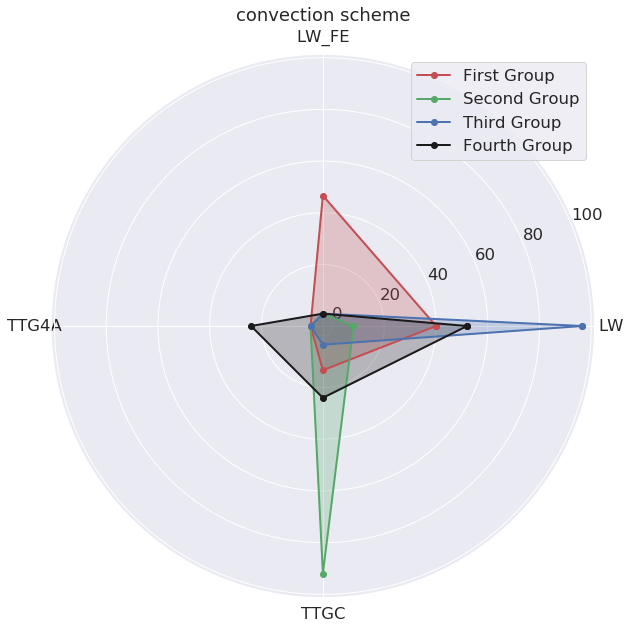

In [132]:

plot_polar(dummies_convection_scheme, 'convection scheme',
          df_comp6.groupby('k_means_pca').sum()[dummies_convection_scheme.columns],4)

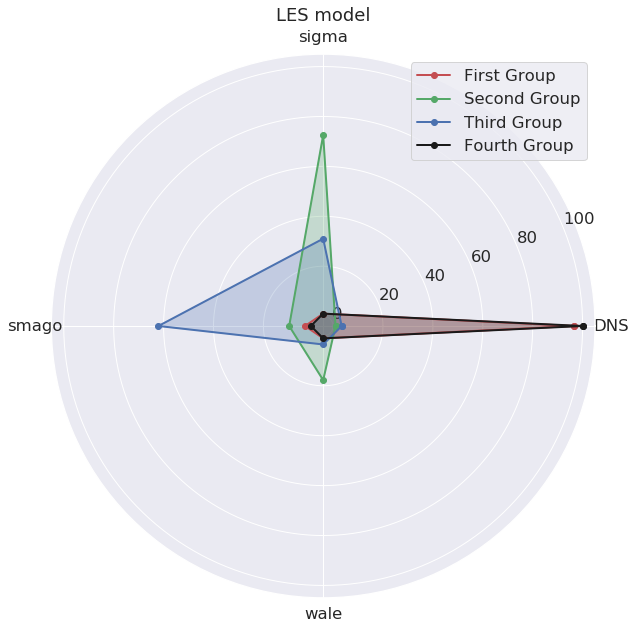

In [133]:
plot_polar(dummies_LES_model, 'LES model',
          df_comp6.groupby('k_means_pca').sum()[dummies_LES_model.columns], 4)

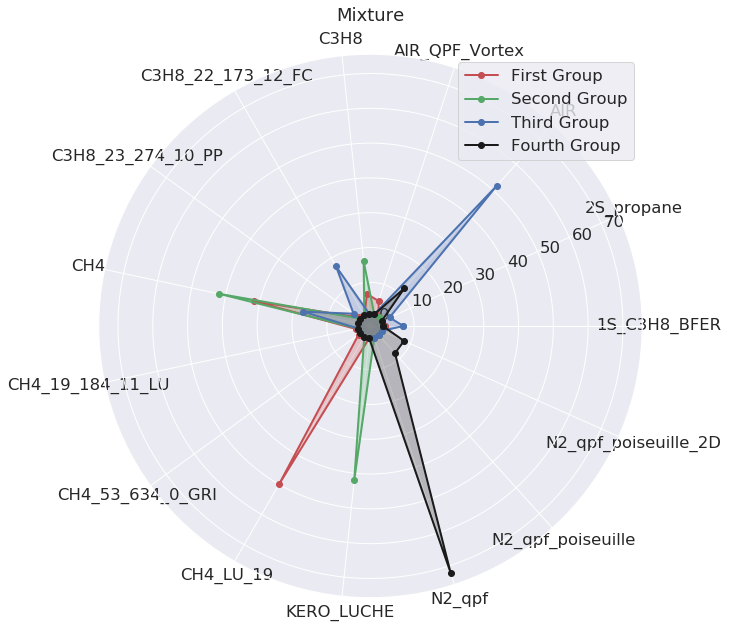

In [134]:
plot_polar(dummies_mixturename, 'Mixture',
          df_comp6.groupby('k_means_pca').sum()[dummies_mixturename.columns], 4)

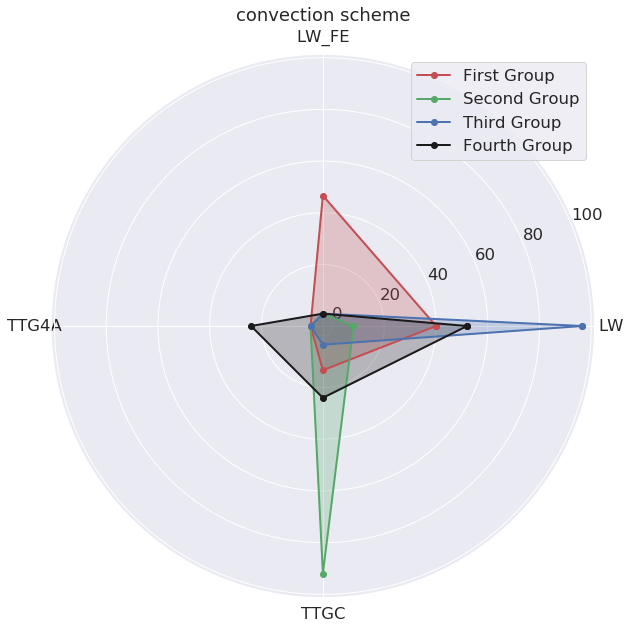

In [135]:
plot_polar(dummies_convection_scheme, 'convection scheme',
          df_comp6.groupby('k_means_pca').sum()[dummies_convection_scheme.columns],4)

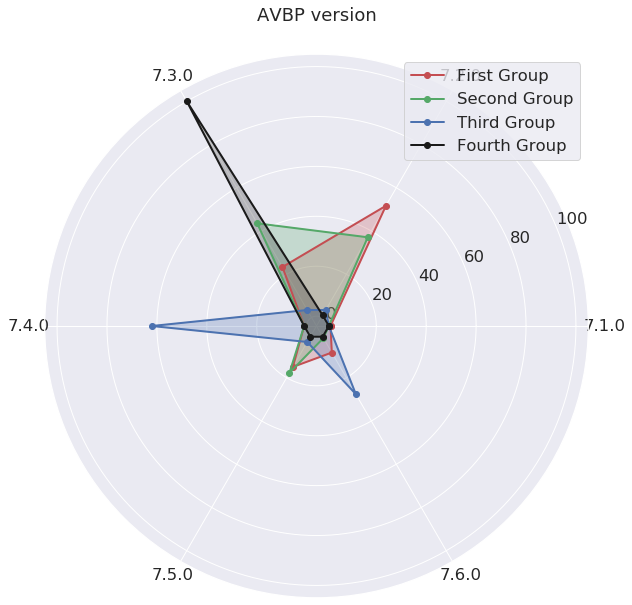

In [136]:
plot_polar(dummies_avbpversion, 'AVBP version', 
           df_comp6.groupby('k_means_pca').sum()[dummies_avbpversion.columns], 4)

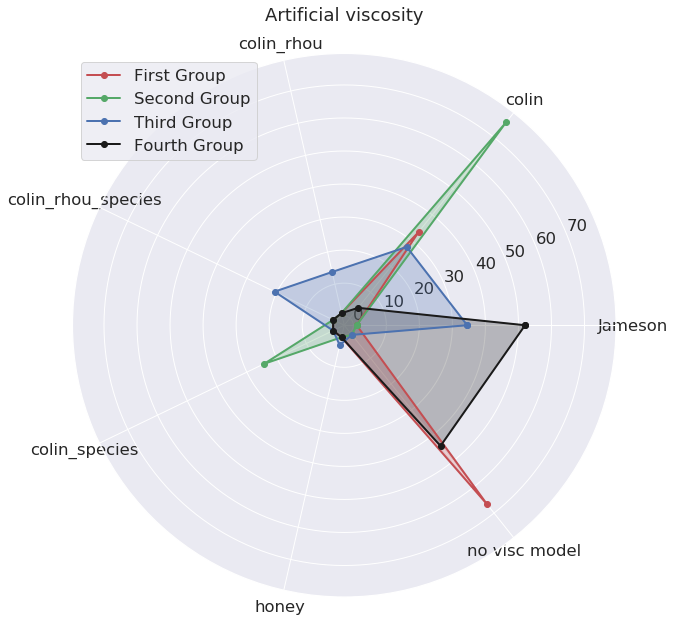

In [137]:
plot_polar(dummies_viscoartif, 'Artificial viscosity', 
           df_comp6.groupby('k_means_pca').sum()[dummies_viscoartif.columns], 4)